In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [3]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

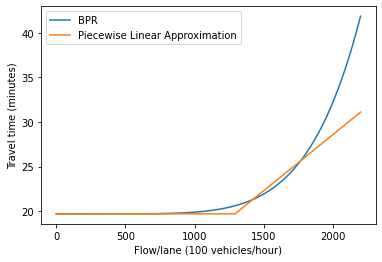

In [4]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [5]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 44.4 $/hr; median: 33.6 $/hr


Text(0, 0.5, '% of population')

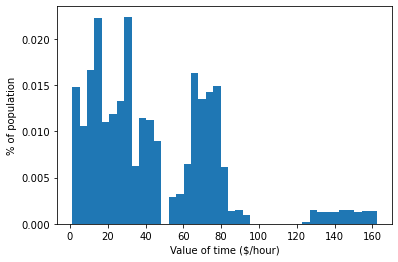

In [6]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [7]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.2
23.22
29.8
33.55
43.46
63.29
68.43
74.5
80.04
162.21


# Solver 1, Budget:

In [21]:
def OptPL_budget(toll, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope, is_pure = False):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + \
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + \
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + \
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of all flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(3) for t in range(T)))
    # Just to compare with original code:
    if is_pure:
        m1.addConstrs((users_el[1, t]==0 for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == num_eligible for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B * num_eligible))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum(a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( toll*users_el[1,t]/(vot_eligible[i,t]*num_eligible) for i in range(num_eligible) ) 
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [22]:
def _extract_solution_budget(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [23]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 1 - Budget:

In [24]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:]
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) 

# print("tau_arr:\n", tau_arr)
# print()
# print("B_arr:\n", B_arr)

In [25]:
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)

print("tau_arr:\n", tau_arr)
print()
print("B_arr:\n", B_arr)

tau_arr:
 [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]

B_arr:
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [27]:
t_1 = time.time()

demand_multiplier = [25, 75]

# For saving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_budget_pure/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express (Credit)", "Express (Paying)", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)
        
## Toll and budget lists:
tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print()
        
        # Construct optimization problem:
#         is_pure = False
        is_pure = True
        m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible,  \
                                vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, \
                                fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], \
                                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]), \
                                is_pure = is_pure)

        # Solve optimization problem:
        m_budget.optimize()
        
        print("Optimal solution obtained:", m_budget.status == GRB.OPTIMAL)
        
        # Extract Solution:
        solution_set = _extract_solution_budget(m_budget)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
        
        # Storing data:
        data_edge_flows = np.hstack((np.zeros((5, 1)), solution_set["edge_flows"].T)).reshape(15)
        data_eps_flow = np.hstack((np.zeros((5, 1)), solution_set["eps_flows"].T)).reshape(15)
        data_users_el = solution_set["users_el"].T.reshape(15)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*3))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_budget_pure_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)


t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0
Budget: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166055 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x2b879314
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166040 rows and 99615 columns
Presolve time: 0.22s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal   

Presolve removed 166040 rows and 99615 columns
Presolve time: 0.20s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.5088

   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
   8   8.50880702e+05  8.50880702e+05  8.61e-13 2.13e-14  2.92e-10     0s

Barrier solved model in 8 iterations and 0.18 seconds (0.15 work units)
Optimal objective 8.50880702e+05

Optimal solution obtained: True

Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]


Toll: 0.0
Budget: 45.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with

Optimal objective 8.50880702e+05

Optimal solution obtained: True

Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]


Toll: 0.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166055 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x2b879314
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166040 rows and 99615 columns
Presolve time: 0.20s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less

  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166040 rows and 99615 columns
Presolve time: 0.20s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   

  18   8.52531188e+05  8.52450976e+05  2.89e-07 3.35e-11  1.21e-03     0s
  19   8.52509501e+05  8.52479452e+05  8.90e-08 9.92e-12  4.52e-04     0s
  20   8.52502775e+05  8.52487675e+05  4.25e-08 4.38e-12  2.27e-04     0s
  21   8.52499428e+05  8.52491635e+05  2.08e-08 1.99e-12  1.17e-04     0s
  22   8.52498072e+05  8.52493191e+05  1.23e-08 1.21e-12  7.35e-05     0s
  23   8.52497291e+05  8.52494096e+05  7.03e-09 7.11e-13  4.81e-05     0s
  24   8.52496609e+05  8.52494864e+05  3.19e-09 3.41e-13  2.63e-05     0s
  25   8.52496174e+05  8.52495347e+05  2.81e-09 1.28e-13  1.24e-05     0s
  26   8.52496034e+05  8.52495513e+05  3.06e-10 5.68e-14  7.83e-06     0s
  27   8.52495874e+05  8.52495675e+05  7.53e-11 5.68e-14  2.99e-06     0s
  28   8.52495820e+05  8.52495731e+05  4.41e-09 5.68e-14  1.34e-06     0s
  29   8.52495777e+05  8.52495774e+05  3.95e-10 5.68e-14  4.37e-08     0s
  30   8.52495776e+05  8.52495775e+05  1.11e-11 5.68e-14  2.44e-09     0s
  31   8.52495775e+05  8.52495775e+05 

Optimal objective 8.52495775e+05

Optimal solution obtained: True

Toll: 1.0
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x4926aaa0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

  

   0  -5.67038006e+09 -2.12470163e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.36693412e+06 -8.70954381e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10438743e+06 -3.18584786e+06  1.44e+02 1.68e-02  8.61e+01     0s
   3   9.33172250e+05  2.74565511e+05  2.26e+00 2.63e-04  9.99e+00     0s
   4   8.72918468e+05  8.02566540e+05  1.03e-01 1.19e-05  1.06e+00     0s
   5   8.66105669e+05  8.42179706e+05  3.25e-02 3.78e-06  3.61e-01     0s
   6   8.56430884e+05  8.35595193e+05  1.38e-02 1.60e-06  3.14e-01     0s
   7   8.56548057e+05  8.38837568e+05  9.95e-03 1.16e-06  2.67e-01     0s
   8   8.56071047e+05  8.41850843e+05  1.45e-03 1.69e-07  2.14e-01     0s
   9   8.55912552e+05  8.44068046e+05  1.03e-03 1.19e-07  1.78e-01     0s
  10   8.53698929e+05  8.49843227e+05  3.36e-05 3.90e-09  5.80e-02     0s
  11   8.53001537e+05  8.51512011e+05  1.02e-05 1.18e-09  2.24e-02     1s
  12   8.52804345e+05  8.51973791e+05  4.78e-06 5.55e-10  1.25e-02     1s
  13   8.52699155e+05  8.52168661e+05 

  15   8.52597316e+05  8.52348153e+05  1.14e-06 1.32e-10  3.75e-03     0s
  16   8.52563791e+05  8.52402693e+05  7.26e-07 8.38e-11  2.42e-03     0s
  17   8.52551860e+05  8.52421217e+05  5.39e-07 6.24e-11  1.97e-03     0s
  18   8.52531188e+05  8.52450976e+05  2.89e-07 3.35e-11  1.21e-03     0s
  19   8.52509501e+05  8.52479452e+05  8.90e-08 9.92e-12  4.52e-04     0s
  20   8.52502775e+05  8.52487675e+05  4.25e-08 4.38e-12  2.27e-04     0s
  21   8.52499428e+05  8.52491635e+05  2.08e-08 1.99e-12  1.17e-04     0s
  22   8.52498072e+05  8.52493191e+05  1.23e-08 1.21e-12  7.35e-05     0s
  23   8.52497291e+05  8.52494096e+05  7.03e-09 7.11e-13  4.81e-05     0s
  24   8.52496609e+05  8.52494864e+05  3.19e-09 3.41e-13  2.63e-05     0s
  25   8.52496174e+05  8.52495347e+05  2.81e-09 1.28e-13  1.24e-05     0s
  26   8.52496034e+05  8.52495513e+05  3.06e-10 5.68e-14  7.83e-06     0s
  27   8.52495874e+05  8.52495675e+05  7.53e-11 5.68e-14  2.99e-06     0s
  28   8.52495820e+05  8.52495731e+05 

  30   8.52495776e+05  8.52495775e+05  1.11e-11 5.68e-14  2.44e-09     0s
  31   8.52495775e+05  8.52495775e+05  2.50e-12 8.53e-14  2.45e-12     0s

Barrier solved model in 31 iterations and 0.44 seconds (0.32 work units)
Optimal objective 8.52495775e+05

Optimal solution obtained: True

Toll: 1.0
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xee84c30f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.20s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 1

 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.67038006e+09 -2.12470163e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.36693412e+06 -8.70954381e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10438743e+06 -3.18584786e+06  1.44e+02 1.68e-02  8.61e+01     0s
   3   9.33172250e+05  2.74565511e+05  2.26e+00 2.63e-04  9.99e+00     0s
   4   8.72918468e+05  8.02566540e+05  1.03e-01 1.19e-05  1.06e+00     0s
   5   8.66105669e+05  8.42179706e+05  3.25e-02 3.78e-06  3.61e-01     0s
   6   8.56430884e+05  8.35595193e+05  1.38e-02 1.60e-06  3.14e-01     0s
   7   8.56548057e+05  8.38837568e+05  9.95e-03 1.16e-06  2.67e-01     0s
   8   8.56071047e+05  8.41850843e+05  1.45e-03 1.69e-07  2.14e-01     0s
   9   8.55912552e+05  8.44068046e+05  1.03e-03 1.19e-07  

  11   8.53001537e+05  8.51512011e+05  1.02e-05 1.18e-09  2.24e-02     0s
  12   8.52804345e+05  8.51973791e+05  4.78e-06 5.55e-10  1.25e-02     0s
  13   8.52699155e+05  8.52168661e+05  2.72e-06 3.16e-10  7.98e-03     0s
  14   8.52623765e+05  8.52304113e+05  1.60e-06 1.85e-10  4.81e-03     0s
  15   8.52597316e+05  8.52348153e+05  1.14e-06 1.32e-10  3.75e-03     0s
  16   8.52563791e+05  8.52402693e+05  7.26e-07 8.38e-11  2.42e-03     0s
  17   8.52551860e+05  8.52421217e+05  5.39e-07 6.24e-11  1.97e-03     0s
  18   8.52531188e+05  8.52450976e+05  2.89e-07 3.35e-11  1.21e-03     0s
  19   8.52509501e+05  8.52479452e+05  8.90e-08 9.92e-12  4.52e-04     0s
  20   8.52502775e+05  8.52487675e+05  4.25e-08 4.38e-12  2.27e-04     0s
  21   8.52499428e+05  8.52491635e+05  2.08e-08 1.99e-12  1.17e-04     0s
  22   8.52498072e+05  8.52493191e+05  1.23e-08 1.21e-12  7.35e-05     0s
  23   8.52497291e+05  8.52494096e+05  7.03e-09 7.11e-13  4.81e-05     0s
  24   8.52496609e+05  8.52494864e+05 

  26   8.52496034e+05  8.52495513e+05  3.06e-10 5.68e-14  7.83e-06     0s
  27   8.52495874e+05  8.52495675e+05  7.53e-11 5.68e-14  2.99e-06     0s
  28   8.52495820e+05  8.52495731e+05  4.41e-09 5.68e-14  1.34e-06     0s
  29   8.52495777e+05  8.52495774e+05  3.95e-10 5.68e-14  4.37e-08     0s
  30   8.52495776e+05  8.52495775e+05  1.11e-11 5.68e-14  2.44e-09     0s
  31   8.52495775e+05  8.52495775e+05  2.50e-12 8.53e-14  2.45e-12     1s

Barrier solved model in 31 iterations and 0.51 seconds (0.32 work units)
Optimal objective 8.52495775e+05

Optimal solution obtained: True

Toll: 1.0
Budget: 90.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x6653b39e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix rang

   2   1.16867155e+06 -3.12785571e+06  8.01e+01 9.30e-03  7.67e+01     0s
   3   9.56601755e+05  4.52202952e+05  1.54e+00 1.79e-04  7.64e+00     0s
   4   8.84661597e+05  8.27255443e+05  2.73e-02 3.17e-06  8.64e-01     0s
   5   8.73731782e+05  8.26974291e+05  1.90e-02 2.21e-06  7.04e-01     0s
   6   8.66508514e+05  8.53777849e+05  8.76e-04 1.02e-07  1.92e-01     0s
   7   8.61703963e+05  8.57543202e+05  2.58e-04 3.00e-08  6.26e-02     0s
   8   8.59815834e+05  8.58772087e+05  4.68e-05 5.43e-09  1.57e-02     0s
   9   8.59350598e+05  8.59054784e+05  1.15e-05 1.33e-09  4.45e-03     0s
  10   8.59232710e+05  8.59122479e+05  3.60e-06 4.17e-10  1.66e-03     0s
  11   8.59197013e+05  8.59145322e+05  1.62e-06 1.88e-10  7.78e-04     0s
  12   8.59181028e+05  8.59155374e+05  7.75e-07 8.97e-11  3.86e-04     0s
  13   8.59174319e+05  8.59159619e+05  4.39e-07 5.01e-11  2.21e-04     0s
  14   8.59170699e+05  8.59161917e+05  1.23e-06 2.92e-11  1.32e-04     0s
  15   8.59168646e+05  8.59163226e+05 

  15   8.54130972e+05  8.53747470e+05  2.95e-05 3.42e-09  5.77e-03     0s
  16   8.54089749e+05  8.53794155e+05  2.26e-05 2.62e-09  4.45e-03     0s
  17   8.54059006e+05  8.53828015e+05  1.76e-05 2.04e-09  3.48e-03     0s
  18   8.54038283e+05  8.53850791e+05  1.42e-05 1.65e-09  2.82e-03     0s
  19   8.54020865e+05  8.53869829e+05  1.14e-05 1.32e-09  2.27e-03     0s
  20   8.54009701e+05  8.53881796e+05  9.64e-06 1.12e-09  1.92e-03     0s
  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05 

  16   8.54089749e+05  8.53794155e+05  2.26e-05 2.62e-09  4.45e-03     0s
  17   8.54059006e+05  8.53828015e+05  1.76e-05 2.04e-09  3.48e-03     0s
  18   8.54038283e+05  8.53850791e+05  1.42e-05 1.65e-09  2.82e-03     0s
  19   8.54020865e+05  8.53869829e+05  1.14e-05 1.32e-09  2.27e-03     0s
  20   8.54009701e+05  8.53881796e+05  9.64e-06 1.12e-09  1.92e-03     0s
  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     0s
  29   8.53957838e+05  8.53935165e+05 

  17   8.54059006e+05  8.53828015e+05  1.76e-05 2.04e-09  3.48e-03     0s
  18   8.54038283e+05  8.53850791e+05  1.42e-05 1.65e-09  2.82e-03     0s
  19   8.54020865e+05  8.53869829e+05  1.14e-05 1.32e-09  2.27e-03     0s
  20   8.54009701e+05  8.53881796e+05  9.64e-06 1.12e-09  1.92e-03     0s
  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     0s
  29   8.53957838e+05  8.53935165e+05  1.26e-06 1.46e-10  3.41e-04     0s
  30   8.53952887e+05  8.53939790e+05 

  18   8.54038283e+05  8.53850791e+05  1.42e-05 1.65e-09  2.82e-03     0s
  19   8.54020865e+05  8.53869829e+05  1.14e-05 1.32e-09  2.27e-03     0s
  20   8.54009701e+05  8.53881796e+05  9.64e-06 1.12e-09  1.92e-03     0s
  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     0s
  29   8.53957838e+05  8.53935165e+05  1.26e-06 1.46e-10  3.41e-04     0s
  30   8.53952887e+05  8.53939790e+05  6.11e-07 7.02e-11  1.97e-04     0s
  31   8.53950524e+05  8.53942031e+05 

  19   8.54020865e+05  8.53869829e+05  1.14e-05 1.32e-09  2.27e-03     0s
  20   8.54009701e+05  8.53881796e+05  9.64e-06 1.12e-09  1.92e-03     0s
  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     1s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     1s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     1s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     1s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     1s
  29   8.53957838e+05  8.53935165e+05  1.26e-06 1.46e-10  3.41e-04     1s
  30   8.53952887e+05  8.53939790e+05  6.11e-07 7.02e-11  1.97e-04     1s
  31   8.53950524e+05  8.53942031e+05  3.53e-07 4.05e-11  1.28e-04     1s
  32   8.53948370e+05  8.53944075e+05 

  20   8.54009701e+05  8.53881796e+05  9.64e-06 1.12e-09  1.92e-03     0s
  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     0s
  29   8.53957838e+05  8.53935165e+05  1.26e-06 1.46e-10  3.41e-04     0s
  30   8.53952887e+05  8.53939790e+05  6.11e-07 7.02e-11  1.97e-04     0s
  31   8.53950524e+05  8.53942031e+05  3.53e-07 4.05e-11  1.28e-04     0s
  32   8.53948370e+05  8.53944075e+05  1.32e-07 1.51e-11  6.46e-05     0s
  33   8.53947085e+05  8.53945316e+05 

  21   8.54001572e+05  8.53890605e+05  8.36e-06 9.70e-10  1.67e-03     0s
  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     0s
  29   8.53957838e+05  8.53935165e+05  1.26e-06 1.46e-10  3.41e-04     0s
  30   8.53952887e+05  8.53939790e+05  6.11e-07 7.02e-11  1.97e-04     0s
  31   8.53950524e+05  8.53942031e+05  3.53e-07 4.05e-11  1.28e-04     0s
  32   8.53948370e+05  8.53944075e+05  1.32e-07 1.51e-11  6.46e-05     0s
  33   8.53947085e+05  8.53945316e+05  4.64e-08 5.18e-12  2.66e-05     0s
  34   8.53946614e+05  8.53945773e+05 

  22   8.53993747e+05  8.53898980e+05  7.13e-06 8.27e-10  1.43e-03     0s
  23   8.53988277e+05  8.53904791e+05  6.27e-06 7.28e-10  1.26e-03     0s
  24   8.53984554e+05  8.53908548e+05  5.39e-06 6.25e-10  1.14e-03     0s
  25   8.53979896e+05  8.53913153e+05  4.42e-06 5.13e-10  1.00e-03     0s
  26   8.53971101e+05  8.53922376e+05  3.20e-06 3.71e-10  7.33e-04     0s
  27   8.53966895e+05  8.53926596e+05  2.64e-06 3.06e-10  6.06e-04     0s
  28   8.53962204e+05  8.53931195e+05  2.02e-06 2.34e-10  4.67e-04     0s
  29   8.53957838e+05  8.53935165e+05  1.26e-06 1.46e-10  3.41e-04     1s
  30   8.53952887e+05  8.53939790e+05  6.11e-07 7.02e-11  1.97e-04     1s
  31   8.53950524e+05  8.53942031e+05  3.53e-07 4.05e-11  1.28e-04     1s
  32   8.53948370e+05  8.53944075e+05  1.32e-07 1.51e-11  6.46e-05     1s
  33   8.53947085e+05  8.53945316e+05  4.64e-08 5.18e-12  2.66e-05     1s
  34   8.53946614e+05  8.53945773e+05  1.92e-08 2.14e-12  1.27e-05     1s
  35   8.53946405e+05  8.53945976e+05 

Optimal objective 8.71433866e+05

Optimal solution obtained: True

Toll: 3.0000000000000004
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x857c0a36
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Thre

  12   8.55857387e+05  8.54395326e+05  9.03e-06 1.05e-09  2.20e-02     0s
  13   8.55651488e+05  8.54714098e+05  5.68e-06 6.59e-10  1.41e-02     0s
  14   8.55528589e+05  8.54882216e+05  3.30e-06 3.83e-10  9.73e-03     0s
  15   8.55456191e+05  8.54977286e+05  2.42e-06 2.81e-10  7.21e-03     0s
  16   8.55406943e+05  8.55040603e+05  1.63e-06 1.89e-10  5.51e-03     0s
  17   8.55379283e+05  8.55074080e+05  1.25e-06 1.45e-10  4.59e-03     0s
  18   8.55337048e+05  8.55125377e+05  8.55e-07 9.89e-11  3.19e-03     0s
  19   8.55313342e+05  8.55153461e+05  6.47e-07 7.43e-11  2.41e-03     0s
  20   8.55299242e+05  8.55169883e+05  5.22e-07 5.99e-11  1.95e-03     0s
  21   8.55288199e+05  8.55182668e+05  4.23e-07 4.87e-11  1.59e-03     0s
  22   8.55279407e+05  8.55192714e+05  3.19e-07 3.60e-11  1.30e-03     0s
  23   8.55266726e+05  8.55206922e+05  2.17e-07 2.45e-11  9.00e-04     0s
  24   8.55260182e+05  8.55214145e+05  1.66e-07 1.88e-11  6.93e-04     0s
  25   8.55256265e+05  8.55218451e+05 

  18   8.55337048e+05  8.55125377e+05  8.55e-07 9.89e-11  3.19e-03     0s
  19   8.55313342e+05  8.55153461e+05  6.47e-07 7.43e-11  2.41e-03     0s
  20   8.55299242e+05  8.55169883e+05  5.22e-07 5.99e-11  1.95e-03     0s
  21   8.55288199e+05  8.55182668e+05  4.23e-07 4.87e-11  1.59e-03     0s
  22   8.55279407e+05  8.55192714e+05  3.19e-07 3.60e-11  1.30e-03     0s
  23   8.55266726e+05  8.55206922e+05  2.17e-07 2.45e-11  9.00e-04     0s
  24   8.55260182e+05  8.55214145e+05  1.66e-07 1.88e-11  6.93e-04     0s
  25   8.55256265e+05  8.55218451e+05  1.36e-07 1.54e-11  5.69e-04     0s
  26   8.55252524e+05  8.55222667e+05  1.06e-07 1.05e-11  4.49e-04     0s
  27   8.55248278e+05  8.55227345e+05  7.22e-08 6.04e-12  3.15e-04     0s
  28   8.55246278e+05  8.55229611e+05  2.93e-08 3.28e-12  2.51e-04     0s
  29   8.55241892e+05  8.55234286e+05  6.50e-09 5.68e-13  1.14e-04     0s
  30   8.55240694e+05  8.55235517e+05  1.73e-08 3.20e-13  7.79e-05     0s
  31   8.55239503e+05  8.55236733e+05 

  24   8.55260182e+05  8.55214145e+05  1.66e-07 1.88e-11  6.93e-04     0s
  25   8.55256265e+05  8.55218451e+05  1.36e-07 1.54e-11  5.69e-04     0s
  26   8.55252524e+05  8.55222667e+05  1.06e-07 1.05e-11  4.49e-04     0s
  27   8.55248278e+05  8.55227345e+05  7.22e-08 6.04e-12  3.15e-04     0s
  28   8.55246278e+05  8.55229611e+05  2.93e-08 3.28e-12  2.51e-04     0s
  29   8.55241892e+05  8.55234286e+05  6.50e-09 5.68e-13  1.14e-04     0s
  30   8.55240694e+05  8.55235517e+05  1.73e-08 3.20e-13  7.79e-05     0s
  31   8.55239503e+05  8.55236733e+05  5.70e-09 1.14e-13  4.17e-05     0s
  32   8.55238904e+05  8.55237339e+05  2.65e-09 5.68e-14  2.35e-05     0s
  33   8.55238344e+05  8.55237906e+05  3.87e-12 5.68e-14  6.60e-06     0s
  34   8.55238126e+05  8.55238124e+05  6.10e-09 5.68e-14  3.01e-08     0s
  35   8.55238125e+05  8.55238125e+05  9.30e-11 8.53e-14  3.02e-11     0s

Barrier solved model in 35 iterations and 0.36 seconds (0.34 work units)
Optimal objective 8.55238125e+05

Opti

  30   8.55240694e+05  8.55235517e+05  1.73e-08 3.20e-13  7.79e-05     0s
  31   8.55239503e+05  8.55236733e+05  5.70e-09 1.14e-13  4.17e-05     0s
  32   8.55238904e+05  8.55237339e+05  2.65e-09 5.68e-14  2.35e-05     0s
  33   8.55238344e+05  8.55237906e+05  3.87e-12 5.68e-14  6.60e-06     0s
  34   8.55238126e+05  8.55238124e+05  6.10e-09 5.68e-14  3.01e-08     0s
  35   8.55238125e+05  8.55238125e+05  9.30e-11 8.53e-14  3.02e-11     0s

Barrier solved model in 35 iterations and 0.36 seconds (0.34 work units)
Optimal objective 8.55238125e+05

Optimal solution obtained: True

Toll: 3.0000000000000004
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x67a102b1
Model has 10 quadratic objective terms
Coefficient statistics


Barrier solved model in 35 iterations and 0.37 seconds (0.34 work units)
Optimal objective 8.55238125e+05

Optimal solution obtained: True

Toll: 3.0000000000000004
Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x5ca85107
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 8e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB 

Model fingerprint: 0x1cd3d5c5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.56151083e+09 -2.11913172e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.15194774e+06 -8.65384273e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.13868512e+06 -3.13077441e+06  1.43e+02 1.66e-02  8.59e+01     0s
   3   9.74414256e+05  3.21492


Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.56151083e+09 -2.11913172e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.15194774e+06 -8.65384273e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.13868512e+06 -3.13077441e+06  1.43e+02 1.66e-02  8.59e+01     0s
   3   9.74414256e+05  3.21492247e+05  2.49e+00 2.89e-04  9.92e+00     0s
   4   8.99069085e+05  8.19823464e+05  1.12e-01 1.30e-05  1.19e+00     0s
   5   8.74566570e+05  8.13196465e+05  6.82e-02 7.91e-06  9.25e-01     0s
   6   8.67747625e+05  8.26719802e+05  2.51e-02 2.91e-06  6.18e-01     0s
   7   8.66918164e+05  8.32063747e+05  1.80e-02 2.09e-06  5.25e-01     0s
   8   8.63603063e+05  8.37757729e+05  3.04e-04 3.54e-08  3.89e-01     0s
   9   8.58252836e+05  8.50346105e+05

   2   1.13868512e+06 -3.13077441e+06  1.43e+02 1.66e-02  8.59e+01     0s
   3   9.74414256e+05  3.21492247e+05  2.49e+00 2.89e-04  9.92e+00     0s
   4   8.99069085e+05  8.19823464e+05  1.12e-01 1.30e-05  1.19e+00     0s
   5   8.74566570e+05  8.13196465e+05  6.82e-02 7.91e-06  9.25e-01     0s
   6   8.67747625e+05  8.26719802e+05  2.51e-02 2.91e-06  6.18e-01     0s
   7   8.66918164e+05  8.32063747e+05  1.80e-02 2.09e-06  5.25e-01     0s
   8   8.63603063e+05  8.37757729e+05  3.04e-04 3.54e-08  3.89e-01     0s
   9   8.58252836e+05  8.50346105e+05  8.22e-05 9.54e-09  1.19e-01     0s
  10   8.56429391e+05  8.53395892e+05  2.51e-05 2.92e-09  4.57e-02     0s
  11   8.56026795e+05  8.54157066e+05  1.32e-05 1.53e-09  2.81e-02     0s
  12   8.55857387e+05  8.54395326e+05  9.03e-06 1.05e-09  2.20e-02     0s
  13   8.55651488e+05  8.54714098e+05  5.68e-06 6.59e-10  1.41e-02     0s
  14   8.55528589e+05  8.54882216e+05  3.30e-06 3.83e-10  9.73e-03     0s
  15   8.55456191e+05  8.54977286e+05 

Optimal objective 8.72160882e+05

Optimal solution obtained: True

Toll: 4.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xd11cbeaa
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

  

  21   8.56463953e+05  8.56329479e+05  2.39e-06 2.78e-10  2.02e-03     0s
  22   8.56452177e+05  8.56340599e+05  1.98e-06 2.30e-10  1.68e-03     0s
  23   8.56444252e+05  8.56348072e+05  1.71e-06 1.98e-10  1.45e-03     0s
  24   8.56439312e+05  8.56352309e+05  1.44e-06 1.67e-10  1.31e-03     0s
  25   8.56431291e+05  8.56359897e+05  1.18e-06 1.37e-10  1.07e-03     0s
  26   8.56425691e+05  8.56364756e+05  8.98e-07 1.04e-10  9.17e-04     0s
  27   8.56421772e+05  8.56368226e+05  7.26e-07 8.41e-11  8.06e-04     0s
  28   8.56417015e+05  8.56372276e+05  5.16e-07 5.95e-11  6.73e-04     0s
  29   8.56409758e+05  8.56379010e+05  3.11e-07 3.56e-11  4.63e-04     0s
  30   8.56404171e+05  8.56384238e+05  1.66e-07 1.89e-11  3.00e-04     0s
  31   8.56399547e+05  8.56388599e+05  7.79e-08 7.18e-12  1.65e-04     0s
  32   8.56396626e+05  8.56391451e+05  3.25e-08 3.27e-12  7.79e-05     0s
  33   8.56394987e+05  8.56393034e+05  5.73e-09 5.97e-13  2.94e-05     0s
  34   8.56394249e+05  8.56393763e+05 

  26   8.56425691e+05  8.56364756e+05  8.98e-07 1.04e-10  9.17e-04     0s
  27   8.56421772e+05  8.56368226e+05  7.26e-07 8.41e-11  8.06e-04     0s
  28   8.56417015e+05  8.56372276e+05  5.16e-07 5.95e-11  6.73e-04     0s
  29   8.56409758e+05  8.56379010e+05  3.11e-07 3.56e-11  4.63e-04     0s
  30   8.56404171e+05  8.56384238e+05  1.66e-07 1.89e-11  3.00e-04     0s
  31   8.56399547e+05  8.56388599e+05  7.79e-08 7.18e-12  1.65e-04     0s
  32   8.56396626e+05  8.56391451e+05  3.25e-08 3.27e-12  7.79e-05     0s
  33   8.56394987e+05  8.56393034e+05  5.73e-09 5.97e-13  2.94e-05     0s
  34   8.56394249e+05  8.56393763e+05  6.52e-10 7.11e-14  7.31e-06     0s
  35   8.56394016e+05  8.56393995e+05  2.96e-12 1.14e-13  3.22e-07     0s
  36   8.56394005e+05  8.56394005e+05  2.78e-09 5.68e-14  1.21e-09     0s

Barrier solved model in 36 iterations and 0.36 seconds (0.35 work units)
Optimal objective 8.56394005e+05

Optimal solution obtained: True

Toll: 4.0
Budget: 35.0

Gurobi Optimizer vers

  31   8.56399547e+05  8.56388599e+05  7.79e-08 7.18e-12  1.65e-04     0s
  32   8.56396626e+05  8.56391451e+05  3.25e-08 3.27e-12  7.79e-05     0s
  33   8.56394987e+05  8.56393034e+05  5.73e-09 5.97e-13  2.94e-05     0s
  34   8.56394249e+05  8.56393763e+05  6.52e-10 7.11e-14  7.31e-06     0s
  35   8.56394016e+05  8.56393995e+05  2.96e-12 1.14e-13  3.22e-07     0s
  36   8.56394005e+05  8.56394005e+05  2.78e-09 5.68e-14  1.21e-09     0s

Barrier solved model in 36 iterations and 0.37 seconds (0.35 work units)
Optimal objective 8.56394005e+05

Optimal solution obtained: True

Toll: 4.0
Budget: 45.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xe28d856b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix rang

  36   8.56394005e+05  8.56394005e+05  2.78e-09 5.68e-14  1.21e-09     0s

Barrier solved model in 36 iterations and 0.37 seconds (0.35 work units)
Optimal objective 8.56394005e+05

Optimal solution obtained: True

Toll: 4.0
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x4974ad8d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA'


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xc022cde1
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 9e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.00707621e+09 -2.11634676e+07  6.64e+06 7.7

  Objective range  [1e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.00707621e+09 -2.11634676e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.54511477e+06 -8.62599222e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15545996e+06 -3.10328638e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.93645630e+05  3.44025582e+05  2.59e+00 3.01e-04  9.88e+00     0s
   4   9.13535545e+05  7.93639959e+05  2.93e-01 3.41e-05  1.81e+00     0s
   5   8.


Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.00707621e+09 -2.11634676e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.54511477e+06 -8.62599222e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15545996e+06 -3.10328638e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.93645630e+05  3.44025582e+05  2.59e+00 3.01e-04  9.88e+00     0s
   4   9.13535545e+05  7.93639959e+05  2.93e-01 3.41e-05  1.81e+00     0s
   5   8.75915906e+05  8.04100306e+05  9.59e-02 1.11e-05  1.08e+00     0s
   6   8.75158574e+05  8.14272554e+05  5.82e-02 6.75e-06  9.17e-01     0s
   7   8.75648973e+05  8.17793435e+05  3.87e-02 4.49e-06  8.71e-01     0s
   8   8.66596692e+05  8.38607692e+05  2.46e-03 2.85e-07  4.21e-01     0s
   9   8.59200039e+05  8.52715103e+05

   1  -4.99915632e+06 -7.94212282e+06  6.37e+03 7.40e-01  1.11e+03     0s
   2   1.23283733e+06 -3.04290234e+06  7.87e+01 9.14e-03  7.64e+01     0s
   3   1.03649599e+06  4.95871387e+05  4.68e+00 5.44e-04  8.30e+00     0s
   4   9.20911043e+05  8.41651630e+05  2.14e-01 2.49e-05  1.20e+00     0s
   5   9.02114687e+05  8.64340786e+05  8.74e-02 1.02e-05  5.70e-01     0s
   6   8.88353804e+05  8.81225762e+05  1.16e-02 1.34e-06  1.08e-01     0s
   7   8.84783939e+05  8.83531224e+05  1.65e-03 1.91e-07  1.89e-02     0s
   8   8.84205710e+05  8.83932714e+05  2.87e-04 3.34e-08  4.11e-03     0s
   9   8.84119138e+05  8.83992730e+05  1.17e-04 1.35e-08  1.90e-03     0s
  10   8.84077388e+05  8.84023588e+05  4.72e-05 5.49e-09  8.11e-04     0s
  11   8.84062637e+05  8.84034183e+05  2.24e-05 2.60e-09  4.29e-04     0s
  12   8.84053449e+05  8.84041166e+05  9.23e-06 1.07e-09  1.85e-04     0s
  13   8.84050365e+05  8.84043426e+05  4.41e-06 5.11e-10  1.05e-04     0s
  14   8.84048225e+05  8.84045029e+05 

   6   8.83896324e+05  8.51071019e+05  2.78e-02 3.23e-06  4.95e-01     0s
   7   8.76725433e+05  8.56716100e+05  1.40e-02 1.63e-06  3.01e-01     0s
   8   8.72266235e+05  8.62740959e+05  5.84e-03 6.78e-07  1.43e-01     0s
   9   8.69920412e+05  8.65385112e+05  2.45e-03 2.84e-07  6.83e-02     0s
  10   8.68060596e+05  8.67136853e+05  3.29e-04 3.82e-08  1.39e-02     0s
  11   8.67703108e+05  8.67426491e+05  7.94e-05 9.22e-09  4.16e-03     0s
  12   8.67591147e+05  8.67516511e+05  1.59e-05 1.85e-09  1.12e-03     0s
  13   8.67565615e+05  8.67537773e+05  4.89e-06 5.68e-10  4.19e-04     0s
  14   8.67556612e+05  8.67545476e+05  1.65e-06 1.91e-10  1.68e-04     0s
  15   8.67553890e+05  8.67547850e+05  7.86e-07 9.10e-11  9.09e-05     0s
  16   8.67551447e+05  8.67550025e+05  5.65e-07 1.53e-11  2.14e-05     0s
  17   8.67551012e+05  8.67550428e+05  2.22e-07 6.05e-12  8.79e-06     0s
  18   8.67550824e+05  8.67550598e+05  3.81e-08 1.04e-12  3.40e-06     0s
  19   8.67550726e+05  8.67550691e+05 

Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.45264159e+09 -2.11356181e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.93872193e+06 -8.59814173e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.17198665e+06 -3.07583076e+06  1.42e+02 1.65e-02  8.56e+01     0s
   3   1.01196785e+06  3.65954987e+05  2.69e+00 3.12e-04  9.83e+00     0s
   4   9.24293761e+05  8.05963817e+05  3.10e-01 3.60e-05  1.79e+00     0s
   5   8.81732757e+05  8.06913536e+05  1.19e-01 1.38e-05  1.13e+00     0s
   6   8.81410454e+05  8.13629939e+05  8.51e-02 9.88e-06  1.02e+00     0s
   7   8.80592854e+05  8.16352006e+05  5.49e-02 6.38e-06  9.68e-0

  13   8.57792202e+05  8.57017037e+05  2.72e-05 3.16e-09  1.17e-02     0s
  14   8.57697039e+05  8.57129099e+05  1.65e-05 1.91e-09  8.55e-03     0s
  15   8.57622619e+05  8.57216960e+05  1.16e-05 1.35e-09  6.10e-03     0s
  16   8.57568141e+05  8.57278596e+05  8.21e-06 9.52e-10  4.36e-03     0s
  17   8.57537123e+05  8.57313172e+05  6.31e-06 7.32e-10  3.37e-03     0s
  18   8.57519502e+05  8.57332571e+05  4.86e-06 5.64e-10  2.81e-03     0s
  19   8.57492583e+05  8.57361974e+05  3.37e-06 3.90e-10  1.97e-03     0s
  20   8.57475769e+05  8.57380115e+05  2.15e-06 2.48e-10  1.44e-03     0s
  21   8.57461446e+05  8.57395333e+05  1.47e-06 1.70e-10  9.95e-04     0s
  22   8.57451705e+05  8.57405596e+05  1.02e-06 1.17e-10  6.94e-04     0s
  23   8.57446025e+05  8.57411580e+05  6.84e-07 7.90e-11  5.18e-04     0s
  24   8.57440169e+05  8.57417738e+05  3.71e-07 4.27e-11  3.38e-04     0s
  25   8.57433885e+05  8.57424359e+05  7.82e-08 5.29e-12  1.43e-04     0s
  26   8.57431243e+05  8.57427036e+05 


Optimal solution obtained: True

Toll: 5.0
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xa60dc673
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [2e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective        

   4   9.24293761e+05  8.05963817e+05  3.10e-01 3.60e-05  1.79e+00     0s
   5   8.81732757e+05  8.06913536e+05  1.19e-01 1.38e-05  1.13e+00     0s
   6   8.81410454e+05  8.13629939e+05  8.51e-02 9.88e-06  1.02e+00     0s
   7   8.80592854e+05  8.16352006e+05  5.49e-02 6.38e-06  9.68e-01     0s
   8   8.73858982e+05  8.30527602e+05  1.01e-02 1.17e-06  6.52e-01     0s
   9   8.60845257e+05  8.52130677e+05  1.12e-03 1.30e-07  1.31e-01     0s
  10   8.58157705e+05  8.56521076e+05  8.32e-05 9.66e-09  2.46e-02     0s
  11   8.57915605e+05  8.56867394e+05  3.95e-05 4.59e-09  1.58e-02     0s
  12   8.57849755e+05  8.56950478e+05  3.38e-05 3.93e-09  1.35e-02     0s
  13   8.57792202e+05  8.57017037e+05  2.72e-05 3.16e-09  1.17e-02     0s
  14   8.57697039e+05  8.57129099e+05  1.65e-05 1.91e-09  8.55e-03     0s
  15   8.57622619e+05  8.57216960e+05  1.16e-05 1.35e-09  6.10e-03     0s
  16   8.57568141e+05  8.57278596e+05  8.21e-06 9.52e-10  4.36e-03     0s
  17   8.57537123e+05  8.57313172e+05 

  23   8.57446025e+05  8.57411580e+05  6.84e-07 7.90e-11  5.18e-04     0s
  24   8.57440169e+05  8.57417738e+05  3.71e-07 4.27e-11  3.38e-04     0s
  25   8.57433885e+05  8.57424359e+05  7.82e-08 5.29e-12  1.43e-04     0s
  26   8.57431243e+05  8.57427036e+05  1.25e-08 6.32e-13  6.33e-05     0s
  27   8.57429560e+05  8.57428728e+05  1.13e-09 1.14e-13  1.25e-05     0s
  28   8.57429156e+05  8.57429133e+05  2.41e-09 1.14e-13  3.52e-07     0s
  29   8.57429145e+05  8.57429145e+05  1.32e-09 1.14e-13  3.63e-10     0s

Barrier solved model in 29 iterations and 0.39 seconds (0.30 work units)
Optimal objective 8.57429145e+05

Optimal solution obtained: True

Toll: 5.0
Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xf7631f96
Mo

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.45264159e+09 -2.11356181e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.93872193e+06 -8.59814173e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.17198665e+06 -3.07583076e+06  1.42e+02 1.65e-02  8.56e+01     0s
   3   1.01196785e+06  3.65954987e+05  2.69e+00 3.12e-04  9.83e+00     0s
   4   9.24293761e+05  8.05963817e+05  3.10e-01 3.60e-05  1.79e+00     0s
   5   8.81732757e+05  8.06913536e+05  1.19e-01 1.38e-05  1.13e+00     0s
   6   8.81410454e+05  8.13629939e+05  8.51e-02 9.88e-06  1.02e+00     0s
   7   8.80592854e+05  8.16352006e+05  5.49e-02 6.38e-06  9.68e-01     0s
   8   8.73858982e+05  8.30527602e+05  1.01e-02 1.17e-06  6.52e-01     0s
   9   8.6084525

Optimal objective 8.84384133e+05

Optimal solution obtained: True

Toll: 6.000000000000001
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x8918b3f5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.18s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Thre

  21   8.68272123e+05  8.68272123e+05  2.50e-11 1.14e-13  1.42e-10     0s

Barrier solved model in 21 iterations and 0.45 seconds (0.26 work units)
Optimal objective 8.68272123e+05

Optimal solution obtained: True

Toll: 6.000000000000001
Budget: 25.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xae675739
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier st

  10   8.59790063e+05  8.56651327e+05  3.13e-04 3.64e-08  4.72e-02     0s
  11   8.58839702e+05  8.57829953e+05  1.11e-05 1.28e-09  1.52e-02     0s
  12   8.58627357e+05  8.58061260e+05  4.41e-06 5.12e-10  8.52e-03     0s
  13   8.58598885e+05  8.58091215e+05  3.69e-06 4.29e-10  7.64e-03     0s
  14   8.58586901e+05  8.58103744e+05  3.38e-06 3.92e-10  7.27e-03     0s
  15   8.58510742e+05  8.58185161e+05  2.03e-06 2.36e-10  4.90e-03     0s
  16   8.58451272e+05  8.58248713e+05  1.10e-06 1.28e-10  3.05e-03     0s
  17   8.58411611e+05  8.58290897e+05  5.40e-07 6.13e-11  1.82e-03     0s
  18   8.58390516e+05  8.58313055e+05  2.90e-07 3.29e-11  1.17e-03     0s
  19   8.58373283e+05  8.58331003e+05  1.33e-07 1.51e-11  6.36e-04     0s
  20   8.58366605e+05  8.58338016e+05  5.42e-08 6.26e-12  4.30e-04     0s
  21   8.58356998e+05  8.58347852e+05  9.00e-09 1.01e-12  1.38e-04     0s
  22   8.58353765e+05  8.58351138e+05  2.94e-09 1.14e-13  3.95e-05     0s
  23   8.58352495e+05  8.58352415e+05 

 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.89820697e+09 -2.11077685e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.33276924e+06 -8.57029125e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.18826610e+06 -3.04840750e+06  1.41e+02 1.64e-02  8.55e+01     0s
   3   1.02939666e+06  3.87293944e+05  2.78e+00 3.23e-04  9.78e+00     0s
   4   9.36066434e+05  7.91684179e+05  4.70e-01 5.46e-05  2.18e+00     0s
   5   8.83707521e+05  8.02193945e+05  1.31e-01 1.53e-05  1.23e+00     0s
   6   8.85771766e+05  8.06938277e+05  1.06e-01 1.23e-05  1.19e+00     0s
   7   8.84039104e+05  8.11937179e+05  5.38e-02 6.24e-06  1.09e+00     0s
   8   8.69745427e+05  8.44458345e+05  4.68e-03 5.43e-07  3.81e-01     0s
   9   8.63254274e+05  8.52542288e+05  1.40e-03 1.62e-07  1.61e-01     0s
  10   8


Barrier solved model in 24 iterations and 0.36 seconds (0.27 work units)
Optimal objective 8.58352455e+05

Optimal solution obtained: True

Toll: 6.000000000000001
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x3ad2558b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 9e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.18s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB o

  12   8.58627357e+05  8.58061260e+05  4.41e-06 5.12e-10  8.52e-03     0s
  13   8.58598885e+05  8.58091215e+05  3.69e-06 4.29e-10  7.64e-03     0s
  14   8.58586901e+05  8.58103744e+05  3.38e-06 3.92e-10  7.27e-03     0s
  15   8.58510742e+05  8.58185161e+05  2.03e-06 2.36e-10  4.90e-03     0s
  16   8.58451272e+05  8.58248713e+05  1.10e-06 1.28e-10  3.05e-03     0s
  17   8.58411611e+05  8.58290897e+05  5.40e-07 6.13e-11  1.82e-03     0s
  18   8.58390516e+05  8.58313055e+05  2.90e-07 3.29e-11  1.17e-03     0s
  19   8.58373283e+05  8.58331003e+05  1.33e-07 1.51e-11  6.36e-04     0s
  20   8.58366605e+05  8.58338016e+05  5.42e-08 6.26e-12  4.30e-04     0s
  21   8.58356998e+05  8.58347852e+05  9.00e-09 1.01e-12  1.38e-04     0s
  22   8.58353765e+05  8.58351138e+05  2.94e-09 1.14e-13  3.95e-05     0s
  23   8.58352495e+05  8.58352415e+05  3.52e-10 1.14e-13  1.21e-06     0s
  24   8.58352455e+05  8.58352455e+05  4.27e-09 1.14e-13  1.27e-09     0s

Barrier solved model in 24 iterations

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.89820697e+09 -2.11077685e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.33276924e+06 -8.57029125e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.18826610e+06 -3.04840750e+06  1.41e+02 1.64e-02  8.55e+01     0s
   3   1.02939666e+06  3.87293944e+05  2.78e+00 3.23e-04  9.78e+00     0s
   4   9.36066434e+05  7.91684179e+05  4.70e-01 5.46e-05  2.18e+00     0s
   5   8.83707521e+05  8.02193945e+05  1.31e-01 1.53e-05  1.23e+00     0s
   6   8.85771766e+05  8.06938277e+05  1.06e-01 1.23e-05  1.19e+00     0s
   7   8.84039104e+05  8.11937179e+05  5.38e-02 6.24e-06  1.09e+00     0s
   8   8.69745427e+05  8.44458345e+05  4.68e-03 5.43e-07  3.81e-01     0s
   9   8.63254274e+05  8.52542288e+05  1.40e-03 1.62e-07  1.61e-01     0s
  10   8.59790063e+05  8.56651327e+05  3.13e-04 3.64e-08  4.72e-02     0s
  11   8.58839702e+05  8.57829953e+05  1.11e-05 1.28e-09  1.52e-02     0s
  12   8.58627357e+05  8.58061260e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.34317003e+09 -2.36300563e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.75958037e+06 -9.57703851e+06  6.34e+03 7.36e-01  1.13e+03     0s
   2   1.18507159e+06 -3.07052688e+06  1.57e+02 1.82e-02  8.84e+01     0s
   3   1.05359821e+06 -4.47111443e+05  3.73e+00 4.33e-04  2.29e+01     0s
   4   9.55483853e+05  7.32648085e+05  3.56e-01 4.13e-05  3.36e+00     0s
   5   9.38091838e+05  7.42413229e+05  2.82e-01 3.27e-05  2.95e+00     0s
   6   9.22796021e+05  7.58076679e+05  3.18e-07 3.27e-11  2.48e+00     0s
   7   9.02471078e+05  8.24279682e+05  6.65e-08 6.93e-12  1.18e+00     0s
   8   8.89418703e+05  8.77204960e+05  5.36e-08 8.53e-13  1.84e-01     0s
   9   8.85911278e+05  8.83060023e+05  1.67e-08 1.35e-13  4.29e-02     0s
  10   8.84854770e+05  8.84490717e+05  2.73e-08 1.14e-13  5.48e-03     0s
  11   8.84739390e+05  8.84634681e+05  7.80

   2   1.22100075e+06 -3.02605030e+06  1.25e+02 1.45e-02  8.33e+01     0s
   3   1.04429829e+06  8.99449745e+04  3.07e+00 3.56e-04  1.45e+01     0s
   4   9.48902817e+05  7.69532894e+05  4.07e-01 4.73e-05  2.71e+00     0s
   5   9.02192804e+05  7.93284837e+05  1.53e-01 1.78e-05  1.64e+00     0s
   6   8.83044280e+05  8.54568992e+05  1.97e-02 2.29e-06  4.29e-01     0s
   7   8.75930995e+05  8.60757456e+05  9.04e-03 1.05e-06  2.29e-01     0s
   8   8.72878448e+05  8.64638234e+05  4.11e-03 4.77e-07  1.24e-01     0s
   9   8.71383500e+05  8.66409390e+05  2.42e-03 2.81e-07  7.49e-02     0s
  10   8.70407554e+05  8.67392773e+05  1.23e-03 1.43e-07  4.54e-02     0s
  11   8.69754239e+05  8.68032026e+05  6.22e-04 7.23e-08  2.59e-02     0s
  12   8.69103882e+05  8.68633011e+05  1.30e-04 1.51e-08  7.09e-03     0s
  13   8.68942985e+05  8.68775811e+05  3.86e-05 4.48e-09  2.52e-03     0s
  14   8.68880593e+05  8.68831094e+05  8.72e-06 1.01e-09  7.45e-04     0s
  15   8.68864981e+05  8.68845180e+05 

   9   8.60162753e+05  8.57874825e+05  3.69e-06 4.28e-10  3.44e-02     0s
  10   8.59373791e+05  8.58993531e+05  7.75e-08 4.95e-12  5.72e-03     0s
  11   8.59187858e+05  8.59183253e+05  3.63e-08 1.14e-13  6.93e-05     0s
  12   8.59185034e+05  8.59185029e+05  1.43e-09 1.14e-13  7.09e-08     0s
  13   8.59185031e+05  8.59185031e+05  2.92e-10 1.14e-13  7.09e-11     0s

Barrier solved model in 13 iterations and 0.27 seconds (0.21 work units)
Optimal objective 8.59185031e+05

Optimal solution obtained: True

Toll: 7.000000000000001
Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x65321bef
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [3e+00, 9e+01]
  QOb


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.34377235e+09 -2.10799189e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.72725669e+06 -8.54244080e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.20429926e+06 -3.02101657e+06  1.40e+02 1.63e-02  8.54e+01     0s
   3   1.04594984e+06  4.08056896e+05  2.87e+00 3.33e-04  9.72e+00     0s
   4   9.52805949e+05  7.74539292e+05  6.14e-01 7.13e-05  2.70e+00     0s
   5   8.83680116e+05  8.01942549e+05  8.32e-02 9.66e-06  1.23e+00     0s
   6   8.87538226e+05  8.05867105e+05  7.43e-02 8.63e-06  1.23e+00     0s
   7   8.84698569e+05  8.28165846e+05  3.12e-02 3.62e-06  8.52e-01     0s
   8   8.62899039e+05  8.53319242e+05  2.38e-05 2.76e-09  1.44e-01     0s
   9   8.60162753e+05  8.57874825e+05  3.69e-06 4.28e-10  3.44e-02     0s
  10   8.59373791e+05  8.58993531e+05  7.75e-08 4.95e-12  5.72e-03     0s
  11   8.59187858e+05  8.59183253e+05  3.63e-08 1.14e-13  6

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x7efa9b95
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [3e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.17s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.34377235e+09 -2.10799189e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.72725669e+06 -8.54244

   8   8.62899039e+05  8.53319242e+05  2.38e-05 2.76e-09  1.44e-01     0s
   9   8.60162753e+05  8.57874825e+05  3.69e-06 4.28e-10  3.44e-02     0s
  10   8.59373791e+05  8.58993531e+05  7.75e-08 4.95e-12  5.72e-03     0s
  11   8.59187858e+05  8.59183253e+05  3.63e-08 1.14e-13  6.93e-05     0s
  12   8.59185034e+05  8.59185029e+05  1.43e-09 1.14e-13  7.09e-08     0s
  13   8.59185031e+05  8.59185031e+05  2.92e-10 1.14e-13  7.09e-11     0s

Barrier solved model in 13 iterations and 0.27 seconds (0.21 work units)
Optimal objective 8.59185031e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x3af45409
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range

  17   8.90310708e+05  8.90310695e+05  8.57e-09 1.14e-13  2.03e-07     0s
  18   8.90310702e+05  8.90310702e+05  9.34e-09 1.14e-13  1.65e-09     0s

Barrier solved model in 18 iterations and 0.31 seconds (0.25 work units)
Optimal objective 8.90310702e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xc0afec4e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 1

  22   8.74411963e+05  8.74411963e+05  4.31e-09 1.14e-13  1.46e-10     0s

Barrier solved model in 22 iterations and 0.35 seconds (0.27 work units)
Optimal objective 8.74411963e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 30.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x1563e9ec
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA'

  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.18s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.78933773e+09 -2.10520693e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.12218429e+06 -8.51459036e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.22008711e+06 -2.99365791e+06  1.40e+02 1.62e-02  8.53e+01     0s
   3   1.06164704e+06  4.28259107e+05  2.95e+00 3.42e-04  9.66e+00     0s
   4   9.63374378e+05  7.85673100e+05  6.33e-01 7

   9   8.62940052e+05  8.57235593e+05  2.11e-03 2.45e-07  8.59e-02     0s
  10   8.60655829e+05  8.59382116e+05  3.10e-04 3.60e-08  1.92e-02     0s
  11   8.60117912e+05  8.59889295e+05  3.84e-06 4.46e-10  3.44e-03     0s
  12   8.60004535e+05  8.60002523e+05  1.66e-08 1.71e-13  3.03e-05     0s
  13   8.60003512e+05  8.60003510e+05  1.48e-11 1.14e-13  3.03e-08     0s
  14   8.60003511e+05  8.60003511e+05  8.55e-11 1.14e-13  3.03e-11     0s

Barrier solved model in 14 iterations and 0.32 seconds (0.22 work units)
Optimal objective 8.60003511e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xfd97ea37
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix rang

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.78933773e+09 -2.10520693e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.12218429e+06 -8.51459036e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.22008711e+06 -2.99365791e+06  1.40e+02 1.62e-02  8.53e+01     0s
   3   1.06164704e+06  4.28259107e+05  2.95e+00 3.42e-04  9.66e+00     0s
   4   9.63374378e+05  7.85673100e+05  6.33e-01 7.35e-05  2.69e+00     0s
   5   8.90326392e+05  8.00056194e+05  1.32e-01 1.53e-05  1.36e+00     0s
   6   8.93896665e+05  8.04106534e+05  1.18e-01 1.37e-05  1.35e+00     0s
   7   8.87964624e+05  8.22662110e+05  5.93e-02 6.89e-06  9.84e-01     0s
   8   8.69540760e+05  8.51103253e+05  1.

  13   8.60003512e+05  8.60003510e+05  1.48e-11 1.14e-13  3.03e-08     0s
  14   8.60003511e+05  8.60003511e+05  8.55e-11 1.14e-13  3.03e-11     0s

Barrier solved model in 14 iterations and 0.27 seconds (0.22 work units)
Optimal objective 8.60003511e+05

Optimal solution obtained: True

Toll: 9.0
Budget: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xf4b82a83
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166041 rows and 66420 columns
Presolve time: 0.15s
Presolved: 15 rows, 33215 columns, 66420 nonzeros
Presolved model has 10

  10   8.96127072e+05  8.95323159e+05  5.46e-09 1.71e-13  1.21e-02     0s
  11   8.95844095e+05  8.95630766e+05  3.14e-09 1.14e-13  3.21e-03     0s
  12   8.95763634e+05  8.95714726e+05  4.25e-07 1.14e-13  7.36e-04     0s
  13   8.95749187e+05  8.95729441e+05  1.01e-06 1.14e-13  2.97e-04     0s
  14   8.95743273e+05  8.95735438e+05  1.10e-06 1.14e-13  1.18e-04     0s
  15   8.95741172e+05  8.95737561e+05  8.98e-07 1.14e-13  5.43e-05     0s
  16   8.95740235e+05  8.95738506e+05  3.74e-07 1.14e-13  2.60e-05     0s
  17   8.95739699e+05  8.95739045e+05  1.33e-07 1.14e-13  9.85e-06     0s
  18   8.95739483e+05  8.95739263e+05  1.15e-08 1.14e-13  3.32e-06     0s
  19   8.95739373e+05  8.95739373e+05  8.12e-09 1.14e-13  3.64e-09     0s

Barrier solved model in 19 iterations and 0.29 seconds (0.25 work units)
Optimal objective 8.95739373e+05

Optimal solution obtained: True

Toll: 9.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model:

   7   8.94220445e+05  8.65447669e+05  3.85e-02 4.47e-06  4.34e-01     0s
   8   8.86783121e+05  8.73167844e+05  1.29e-02 1.50e-06  2.05e-01     0s
   9   8.83892502e+05  8.76108261e+05  6.58e-03 7.65e-07  1.17e-01     0s
  10   8.81250635e+05  8.78607624e+05  1.73e-03 2.01e-07  3.98e-02     0s
  11   8.80198243e+05  8.79499137e+05  3.81e-04 4.42e-08  1.05e-02     0s
  12   8.79904595e+05  8.79730074e+05  6.95e-05 8.05e-09  2.63e-03     0s
  13   8.79845399e+05  8.79778204e+05  2.20e-05 2.55e-09  1.01e-03     0s
  14   8.79817630e+05  8.79801523e+05  3.76e-06 4.37e-10  2.42e-04     0s
  15   8.79812223e+05  8.79806268e+05  1.14e-06 1.32e-10  8.96e-05     0s
  16   8.79810125e+05  8.79808137e+05  3.76e-07 2.82e-11  2.99e-05     0s
  17   8.79809325e+05  8.79808886e+05  4.14e-08 4.76e-12  6.61e-06     0s
  18   8.79809119e+05  8.79809082e+05  1.28e-09 1.71e-13  5.57e-07     0s
  19   8.79809101e+05  8.79809100e+05  4.06e-09 1.14e-13  1.26e-08     0s
  20   8.79809100e+05  8.79809100e+05 

  41   8.69589035e+05  8.69589026e+05  6.74e-10 1.14e-13  1.28e-07     0s
  42   8.69589030e+05  8.69589030e+05  1.23e-09 1.71e-13  5.85e-09     0s

Barrier solved model in 42 iterations and 0.49 seconds (0.38 work units)
Optimal objective 8.69589030e+05

Optimal solution obtained: True

Toll: 9.0
Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xbdb9c97c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 1

  12   8.60879884e+05  8.60764178e+05  1.50e-05 1.74e-09  1.74e-03     0s
  13   8.60857593e+05  8.60785059e+05  9.19e-06 1.07e-09  1.09e-03     0s
  14   8.60843799e+05  8.60797767e+05  4.87e-06 5.65e-10  6.93e-04     0s
  15   8.60834018e+05  8.60807015e+05  2.79e-06 3.23e-10  4.06e-04     0s
  16   8.60826944e+05  8.60813634e+05  1.08e-06 1.25e-10  2.00e-04     0s
  17   8.60822325e+05  8.60818054e+05  3.23e-07 3.72e-11  6.43e-05     0s
  18   8.60820838e+05  8.60819459e+05  3.01e-08 2.81e-12  2.07e-05     0s
  19   8.60820175e+05  8.60820116e+05  3.02e-09 1.71e-13  8.87e-07     0s
  20   8.60820145e+05  8.60820145e+05  2.18e-09 2.27e-13  8.96e-10     0s

Barrier solved model in 20 iterations and 0.30 seconds (0.25 work units)
Optimal objective 8.60820145e+05

Optimal solution obtained: True

Toll: 9.0
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 

  12   8.60879884e+05  8.60764178e+05  1.50e-05 1.74e-09  1.74e-03     0s
  13   8.60857593e+05  8.60785059e+05  9.19e-06 1.07e-09  1.09e-03     0s
  14   8.60843799e+05  8.60797767e+05  4.87e-06 5.65e-10  6.93e-04     0s
  15   8.60834018e+05  8.60807015e+05  2.79e-06 3.23e-10  4.06e-04     0s
  16   8.60826944e+05  8.60813634e+05  1.08e-06 1.25e-10  2.00e-04     0s
  17   8.60822325e+05  8.60818054e+05  3.23e-07 3.72e-11  6.43e-05     0s
  18   8.60820838e+05  8.60819459e+05  3.01e-08 2.81e-12  2.07e-05     0s
  19   8.60820175e+05  8.60820116e+05  3.02e-09 1.71e-13  8.87e-07     0s
  20   8.60820145e+05  8.60820145e+05  2.18e-09 2.27e-13  8.96e-10     0s

Barrier solved model in 20 iterations and 0.33 seconds (0.25 work units)
Optimal objective 8.60820145e+05

Optimal solution obtained: True

Toll: 9.0
Budget: 70.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 

  12   8.60879884e+05  8.60764178e+05  1.50e-05 1.74e-09  1.74e-03     0s
  13   8.60857593e+05  8.60785059e+05  9.19e-06 1.07e-09  1.09e-03     0s
  14   8.60843799e+05  8.60797767e+05  4.87e-06 5.65e-10  6.93e-04     0s
  15   8.60834018e+05  8.60807015e+05  2.79e-06 3.23e-10  4.06e-04     0s
  16   8.60826944e+05  8.60813634e+05  1.08e-06 1.25e-10  2.00e-04     0s
  17   8.60822325e+05  8.60818054e+05  3.23e-07 3.72e-11  6.43e-05     0s
  18   8.60820838e+05  8.60819459e+05  3.01e-08 2.81e-12  2.07e-05     0s
  19   8.60820175e+05  8.60820116e+05  3.02e-09 1.71e-13  8.87e-07     0s
  20   8.60820145e+05  8.60820145e+05  2.18e-09 2.27e-13  8.96e-10     0s

Barrier solved model in 20 iterations and 0.31 seconds (0.25 work units)
Optimal objective 8.60820145e+05

Optimal solution obtained: True

Toll: 9.0
Budget: 85.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 

  12   9.12020688e+05  9.11985899e+05  2.58e-05 3.00e-09  5.24e-04     0s
  13   9.12008933e+05  9.11994797e+05  9.96e-06 1.16e-09  2.13e-04     0s
  14   9.12004737e+05  9.11997621e+05  2.53e-06 2.93e-10  1.07e-04     0s
  15   9.12001702e+05  9.12000285e+05  4.79e-07 5.55e-11  2.13e-05     0s
  16   9.12000994e+05  9.12000908e+05  9.51e-09 1.13e-12  1.30e-06     0s
  17   9.12000959e+05  9.12000941e+05  4.80e-09 1.74e-13  2.59e-07     0s
  18   9.12000950e+05  9.12000950e+05  3.54e-09 2.27e-13  2.20e-09     0s

Barrier solved model in 18 iterations and 0.29 seconds (0.24 work units)
Optimal objective 9.12000950e+05

Optimal solution obtained: True

Toll: 10.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xce97672d
Mo


Optimal solution obtained: True

Toll: 10.0
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x1dd11d1d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.18s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective       


Toll: 10.0
Budget: 35.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xe7464a8b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Prim

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.67989992e+09 -2.35465685e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.90635601e+06 -9.75650931e+06  6.30e+03 7.31e-01  1.13e+03     0s
   2   1.29845729e+06 -2.91571986e+06  1.01e+02 1.17e-02  7.94e+01     0s
   3   1.08250797e+06  3.49709362e+05  2.48e+00 2.87e-04  1.12e+01     0s
   4   9.81737867e+05  7.45274839e+05  6.17e-01 7.17e-05  3.58e+00     0s
   5   9.03399578e+05  7.97952224e+05  1.43e-01 1.66e-05  1.59e+00     0s
   6   8.79439590e+05  8.54197763e+05  1.43e-02 1.66e-06  3.80e-01     0s
   7   8.71916932e+05  8.59227996e+05  5.64e-03 6.55e-07  1.91e-01     0s
   8   8.68610568e+05  8.62040995e+05  2.57e-03 2.99e-07  9.89e-02     0s
   9   8.66130048e+05  8.64334766e+05  7.22e-05 8.39e-09  2.70e-02     0s
  10   8.65304076e+05  8.65189717e+05  4.01e-06 4.25e-10  1.72e-03     0s
  11   8.65292703e+05  8.65196537e+05  2.75

   1  -6.91335991e+06 -8.45888954e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.25093097e+06 -2.93903721e+06  1.38e+02 1.61e-02  8.50e+01     0s
   3   1.09056030e+06  4.67045528e+05  3.09e+00 3.59e-04  9.53e+00     0s
   4   9.88586268e+05  7.64030100e+05  8.95e-01 1.04e-04  3.41e+00     0s
   5   8.95289020e+05  7.98766378e+05  1.35e-01 1.57e-05  1.46e+00     0s
   6   9.02171546e+05  8.03274617e+05  1.24e-01 1.44e-05  1.49e+00     0s
   7   8.88679507e+05  8.28951324e+05  4.17e-02 4.84e-06  9.00e-01     0s
   8   8.69010821e+05  8.55063551e+05  6.81e-03 7.91e-07  2.10e-01     0s
   9   8.63218423e+05  8.60171771e+05  9.98e-04 1.16e-07  4.59e-02     0s
  10   8.62071544e+05  8.61159902e+05  1.83e-04 2.12e-08  1.37e-02     0s
  11   8.61719629e+05  8.61481478e+05  3.86e-05 4.48e-09  3.59e-03     0s
  12   8.61632996e+05  8.61562212e+05  9.67e-06 1.12e-09  1.07e-03     0s
  13   8.61609168e+05  8.61584574e+05  2.86e-06 3.32e-10  3.70e-04     0s
  14   8.61600117e+05  8.61593140e+05 

  10   8.62071544e+05  8.61159902e+05  1.83e-04 2.12e-08  1.37e-02     0s
  11   8.61719629e+05  8.61481478e+05  3.86e-05 4.48e-09  3.59e-03     0s
  12   8.61632996e+05  8.61562212e+05  9.67e-06 1.12e-09  1.07e-03     0s
  13   8.61609168e+05  8.61584574e+05  2.86e-06 3.32e-10  3.70e-04     0s
  14   8.61600117e+05  8.61593140e+05  6.43e-07 7.45e-11  1.05e-04     0s
  15   8.61597027e+05  8.61596103e+05  7.68e-08 8.96e-12  1.39e-05     0s
  16   8.61596577e+05  8.61596537e+05  3.49e-09 2.27e-13  6.10e-07     0s
  17   8.61596557e+05  8.61596557e+05  4.90e-09 2.27e-13  9.21e-10     0s

Barrier solved model in 17 iterations and 0.35 seconds (0.23 work units)
Optimal objective 8.61596557e+05

Optimal solution obtained: True

Toll: 10.0
Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1660

Optimal objective 8.61596557e+05

Optimal solution obtained: True

Toll: 11.0
Budget: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xa23f6a47
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166041 rows and 66420 columns
Presolve time: 0.21s
Presolved: 15 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

  


Optimal solution obtained: True

Toll: 11.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x8bcd1d71
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective       


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xa28e3738
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.01254458e+10 -2.35186848e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.32099465e+06 -9.69693651e+06  6.32e+03 7.34e-01  1.13e+03     0s
   2   1.27088807e+06 -2.93438511e

  22   8.74870414e+05  8.74633922e+05  9.86e-05 1.14e-08  3.56e-03     0s
  23   8.74852941e+05  8.74649849e+05  8.45e-05 9.82e-09  3.06e-03     0s
  24   8.74839022e+05  8.74662545e+05  7.34e-05 8.52e-09  2.66e-03     0s
  25   8.74823749e+05  8.74676092e+05  6.13e-05 7.12e-09  2.22e-03     0s
  26   8.74813270e+05  8.74685380e+05  5.30e-05 6.16e-09  1.93e-03     0s
  27   8.74802722e+05  8.74694631e+05  4.47e-05 5.20e-09  1.63e-03     0s
  28   8.74793980e+05  8.74702294e+05  3.79e-05 4.40e-09  1.38e-03     0s
  29   8.74787657e+05  8.74707829e+05  3.29e-05 3.83e-09  1.20e-03     0s
  30   8.74782673e+05  8.74712185e+05  2.91e-05 3.37e-09  1.06e-03     0s
  31   8.74778464e+05  8.74715859e+05  2.58e-05 2.99e-09  9.43e-04     0s
  32   8.74773719e+05  8.74719992e+05  2.21e-05 2.57e-09  8.09e-04     0s
  33   8.74770798e+05  8.74722533e+05  1.98e-05 2.30e-09  7.27e-04     0s
  34   8.74767665e+05  8.74724981e+05  1.62e-05 1.88e-09  6.43e-04     0s
  35   8.74763033e+05  8.74728654e+05 


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xde6e3ca4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.18s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.01260339e+10 -2.09685206e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.30960794e+06 -8.43103916e+06  6.31e+03 7.32e-01  1.11e+03     0s
   2   1.26598909e+06 -2.91177506e

   4   9.98119636e+05  7.61898989e+05  9.92e-01 1.15e-04  3.59e+00     0s
   5   8.99261002e+05  7.99233947e+05  1.66e-01 1.93e-05  1.51e+00     0s
   6   9.08086269e+05  8.04969982e+05  1.54e-01 1.79e-05  1.56e+00     0s
   7   8.84641852e+05  8.33463662e+05  4.66e-02 5.41e-06  7.72e-01     0s
   8   8.68872606e+05  8.55431971e+05  8.76e-03 1.02e-06  2.03e-01     0s
   9   8.64551545e+05  8.59922001e+05  2.62e-03 3.04e-07  6.98e-02     0s
  10   8.62496312e+05  8.62128751e+05  3.69e-06 4.28e-10  5.53e-03     0s
  11   8.62360961e+05  8.62272759e+05  7.17e-07 8.30e-11  1.33e-03     0s
  12   8.62327493e+05  8.62308047e+05  1.33e-07 1.53e-11  2.93e-04     0s
  13   8.62320125e+05  8.62315729e+05  2.69e-08 2.98e-12  6.62e-05     0s
  14   8.62317983e+05  8.62317946e+05  3.03e-09 2.27e-13  5.47e-07     0s
  15   8.62317965e+05  8.62317964e+05  5.20e-09 2.27e-13  2.20e-09     0s

Barrier solved model in 15 iterations and 0.29 seconds (0.22 work units)
Optimal objective 8.62317965e+05

Opti

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x3629ed54
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.31s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         P

  RHS range        [1e+00, 1e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.05709815e+10 -2.34907974e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.74691649e+06 -9.24294524e+06  6.36e+03 7.39e-01  1.13e+03     0s
   2   1.14388790e+06 -3.01004888e+06  2.34e+02 2.72e-02  1.00e+02     0s
   3   1.13812047e+06 -1.60099644e+06  1.01e+01 1.17e-03  4.25e+01     0s
   4   1.02197271e+06  6.78461920e+05  8.66e-01 1.01e-04  5.21e+00     0s
   5   1.00831221e+06  6.82941147e+05  7.91e-01 9.19e-05  4.93e+00     0s
   6   9.53655060e+05  7.27582942e+05

   4   1.01273849e+06  7.10046346e+05  8.31e-01 9.65e-05  4.59e+00     0s
   5   9.77501005e+05  7.26284232e+05  6.15e-01 7.15e-05  3.81e+00     0s
   6   9.65719311e+05  8.04285167e+05  1.28e-01 1.49e-05  2.43e+00     0s
   7   9.60697898e+05  8.09760441e+05  1.04e-01 1.20e-05  2.27e+00     0s
   8   9.22862650e+05  8.12507367e+05  4.45e-02 5.17e-06  1.66e+00     0s
   9   9.06441278e+05  8.69996966e+05  1.34e-02 1.55e-06  5.49e-01     0s
  10   9.02129575e+05  8.81856936e+05  5.34e-03 6.20e-07  3.05e-01     0s
  11   9.00162327e+05  8.86130416e+05  3.64e-03 4.23e-07  2.11e-01     0s
  12   8.98657940e+05  8.89126074e+05  2.44e-03 2.83e-07  1.44e-01     0s
  13   8.97868251e+05  8.90586460e+05  1.85e-03 2.15e-07  1.10e-01     0s
  14   8.97036324e+05  8.92043463e+05  1.05e-03 1.22e-07  7.52e-02     0s
  15   8.96124668e+05  8.93432244e+05  4.15e-04 4.82e-08  4.05e-02     0s
  16   8.95682403e+05  8.94056668e+05  2.22e-04 2.58e-08  2.45e-02     0s
  17   8.95404569e+05  8.94434608e+05 

  RHS range        [1e+00, 5e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.05710215e+10 -2.34908474e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.70997315e+06 -9.69593517e+06  6.31e+03 7.33e-01  1.13e+03     0s
   2   1.30165689e+06 -2.89151222e+06  1.21e+02 1.41e-02  8.26e+01     0s
   3   1.11518829e+06  2.02743166e+05  3.25e+00 3.78e-04  1.39e+01     0s
   4   1.00563367e+06  7.28460975e+05  8.81e-01 1.02e-04  4.21e+00     0s
   5   9.41290894e+05  7.67539815e+05  4.01e-01 4.65e-05  2.63e+00     0s
   6   9.04499180e+05  8.60850268e+05

   1  -7.70101265e+06 -9.69117285e+06  6.30e+03 7.32e-01  1.13e+03     0s
   2   1.31747686e+06 -2.87288423e+06  1.09e+02 1.27e-02  8.06e+01     0s
   3   1.10967713e+06  3.22637703e+05  2.87e+00 3.33e-04  1.20e+01     0s
   4   9.99290691e+05  7.25058518e+05  8.00e-01 9.29e-05  4.16e+00     0s
   5   9.21999927e+05  7.85533393e+05  2.69e-01 3.13e-05  2.06e+00     0s
   6   8.88640075e+05  8.56444683e+05  2.35e-02 2.73e-06  4.85e-01     0s
   7   8.79011255e+05  8.62452611e+05  9.72e-03 1.13e-06  2.50e-01     0s
   8   8.74776203e+05  8.66130994e+05  4.79e-03 5.57e-07  1.30e-01     0s
   9   8.71416897e+05  8.68885059e+05  1.09e-04 1.27e-08  3.81e-02     0s
  10   8.70681711e+05  8.69618853e+05  4.43e-05 5.14e-09  1.60e-02     0s
  11   8.70665809e+05  8.69630183e+05  4.23e-05 4.91e-09  1.56e-02     0s
  12   8.70548803e+05  8.69732840e+05  2.97e-05 3.45e-09  1.23e-02     0s
  13   8.70473180e+05  8.69800071e+05  2.27e-05 2.64e-09  1.01e-02     0s
  14   8.70337808e+05  8.69923844e+05 

   5   9.03568446e+05  8.00102550e+05  2.06e-01 2.39e-05  1.56e+00     0s
   6   9.17498355e+05  8.08425931e+05  1.91e-01 2.22e-05  1.65e+00     0s
   7   8.86974971e+05  8.34303635e+05  5.57e-02 6.47e-06  7.95e-01     0s
   8   8.68402446e+05  8.57866136e+05  6.88e-03 7.99e-07  1.59e-01     0s
   9   8.63952773e+05  8.61996676e+05  7.37e-04 8.56e-08  2.95e-02     0s
  10   8.63045239e+05  8.62930330e+05  1.05e-05 1.22e-09  1.73e-03     0s
  11   8.63009781e+05  8.62966811e+05  3.48e-06 4.03e-10  6.47e-04     0s
  12   8.63000389e+05  8.62976483e+05  1.44e-06 1.67e-10  3.60e-04     0s
  13   8.62994226e+05  8.62982781e+05  4.34e-07 5.03e-11  1.72e-04     0s
  14   8.62989126e+05  8.62987937e+05  1.49e-08 1.58e-12  1.79e-05     0s
  15   8.62988612e+05  8.62988452e+05  3.37e-09 2.27e-13  2.41e-06     0s
  16   8.62988535e+05  8.62988530e+05  3.84e-09 2.27e-13  8.06e-08     0s
  17   8.62988533e+05  8.62988533e+05  4.81e-09 2.27e-13  2.44e-10     0s

Barrier solved model in 17 iterations

  13   8.62994226e+05  8.62982781e+05  4.34e-07 5.03e-11  1.72e-04     0s
  14   8.62989126e+05  8.62987937e+05  1.49e-08 1.58e-12  1.79e-05     0s
  15   8.62988612e+05  8.62988452e+05  3.37e-09 2.27e-13  2.41e-06     0s
  16   8.62988535e+05  8.62988530e+05  3.84e-09 2.27e-13  8.06e-08     0s
  17   8.62988533e+05  8.62988533e+05  4.81e-09 2.27e-13  2.44e-10     0s

Barrier solved model in 17 iterations and 0.31 seconds (0.23 work units)
Optimal objective 8.62988533e+05

Optimal solution obtained: True

Toll: 12.000000000000002
Budget: 85.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x104a82b0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 2e+02]
  QO


Toll: 13.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xefcb33a6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Prima


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xcbcac6a4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.21s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.10165558e+10 -2.34629618e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.13315198e+06 -9.43986870e+06  6.35e+03 7.37e-01  1.13e+03     0s
   2   1.26527827e+06 -2.91110004e


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x3a304b08
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.10165771e+10 -2.34629851e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.11601970e+06 -9.63128463e+06  6.33e+03 7.35e-01  1.13e+03     0s
   2   1.30884180e+06 -2.87551612e

   6   9.08950096e+05  8.62649044e+05  8.09e-02 9.40e-06  7.00e-01     0s
   7   8.96051220e+05  8.66363430e+05  4.20e-02 4.88e-06  4.48e-01     0s
   8   8.88494984e+05  8.72329321e+05  2.19e-02 2.54e-06  2.44e-01     0s
   9   8.83680403e+05  8.76175649e+05  7.26e-03 8.43e-07  1.13e-01     0s
  10   8.82910327e+05  8.76790662e+05  5.90e-03 6.85e-07  9.23e-02     0s
  11   8.82228968e+05  8.77306139e+05  4.72e-03 5.48e-07  7.42e-02     0s
  12   8.81478965e+05  8.77850592e+05  3.44e-03 4.00e-07  5.47e-02     0s
  13   8.80991323e+05  8.78190499e+05  2.64e-03 3.06e-07  4.22e-02     0s
  14   8.80619024e+05  8.78446502e+05  2.03e-03 2.36e-07  3.28e-02     0s
  15   8.80335448e+05  8.78636354e+05  1.58e-03 1.83e-07  2.56e-02     0s
  16   8.80137862e+05  8.78768010e+05  1.27e-03 1.47e-07  2.07e-02     0s
  17   8.79979618e+05  8.78871094e+05  1.02e-03 1.18e-07  1.67e-02     0s
  18   8.79855118e+05  8.78950534e+05  8.28e-04 9.62e-08  1.36e-02     0s
  19   8.79744092e+05  8.79019152e+05 

  10   8.70349282e+05  8.70211585e+05  1.23e-07 1.38e-11  2.07e-03     0s
  11   8.70273738e+05  8.70273496e+05  1.07e-05 2.27e-13  3.60e-06     0s
  12   8.70273590e+05  8.70273589e+05  3.59e-08 2.27e-13  3.60e-09     0s

Barrier solved model in 12 iterations and 0.26 seconds (0.21 work units)
Optimal objective 8.70273590e+05

Optimal solution obtained: True

Toll: 13.0
Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xb4cba4c4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 8e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.21s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.10171646e+10 -2.09128215e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.10342444e+06 -8.37533845e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.29538326e+06 -2.85734688e+06  1.36e+02 1.58e-02  8.45e+01     0s
   3   1.12808764e+06  5.21429526e+05  3.26e+00 3.78e-04  9.29e+00     0s
   4   1.01335954e+06  7.62688133e+05  1.14e+00 1.33e-04  3.82e+00     0s
   5   9.08104088e+05  8.01395892e+05  2.52

   4   1.01335954e+06  7.62688133e+05  1.14e+00 1.33e-04  3.82e+00     0s
   5   9.08104088e+05  8.01395892e+05  2.52e-01 2.92e-05  1.62e+00     0s
   6   9.35788798e+05  8.12662894e+05  2.33e-01 2.71e-05  1.86e+00     0s
   7   8.95097784e+05  8.34426195e+05  6.96e-02 8.08e-06  9.16e-01     0s
   8   8.68713734e+05  8.60317641e+05  7.57e-03 8.79e-07  1.27e-01     0s
   9   8.65101834e+05  8.62543356e+05  1.70e-03 1.97e-07  3.86e-02     0s
  10   8.63786666e+05  8.63465239e+05  1.10e-04 1.28e-08  4.84e-03     0s
  11   8.63656025e+05  8.63571104e+05  2.40e-05 2.78e-09  1.28e-03     0s
  12   8.63623528e+05  8.63598363e+05  5.99e-06 6.96e-10  3.79e-04     0s
  13   8.63614042e+05  8.63606442e+05  1.22e-06 1.41e-10  1.14e-04     0s
  14   8.63610875e+05  8.63609252e+05  1.37e-08 2.27e-13  2.44e-05     0s
  15   8.63610071e+05  8.63610056e+05  1.34e-09 2.27e-13  2.29e-07     0s
  16   8.63610064e+05  8.63610064e+05  3.24e-09 2.27e-13  2.31e-10     0s

Barrier solved model in 16 iterations

  14   9.20066835e+05  9.20065838e+05  1.80e-07 2.27e-13  1.50e-05     0s
  15   9.20066357e+05  9.20066283e+05  9.87e-09 2.27e-13  1.11e-06     0s
  16   9.20066325e+05  9.20066314e+05  1.17e-09 2.27e-13  1.53e-07     0s
  17   9.20066319e+05  9.20066319e+05  1.46e-10 2.27e-13  1.04e-09     0s

Barrier solved model in 17 iterations and 0.32 seconds (0.24 work units)
Optimal objective 9.20066319e+05

Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xb36d25b8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS rang


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x302e8d2e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.14621314e+10 -2.34351244e+07  6.64e+06 7.7


Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 45.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x5f59a9ee
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 6e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Ob

  33   8.79007636e+05  8.78997020e+05  3.75e-06 6.84e-13  1.60e-04     0s
  34   8.79002895e+05  8.79001772e+05  8.41e-07 2.27e-13  1.69e-05     0s
  35   8.79002392e+05  8.79002276e+05  2.34e-08 2.27e-13  1.74e-06     0s
  36   8.79002335e+05  8.79002333e+05  3.09e-10 2.27e-13  2.71e-08     0s
  37   8.79002334e+05  8.79002334e+05  2.12e-09 2.27e-13  1.80e-10     0s

Barrier solved model in 37 iterations and 0.47 seconds (0.36 work units)
Optimal objective 8.79002334e+05

Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x05b1642e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QO

  15   8.67244398e+05  8.67233992e+05  3.89e-06 4.51e-10  1.57e-04     0s
  16   8.67239322e+05  8.67237663e+05  1.42e-06 2.27e-13  2.50e-05     0s
  17   8.67238510e+05  8.67238475e+05  1.18e-07 2.27e-13  5.36e-07     0s
  18   8.67238493e+05  8.67238492e+05  3.64e-12 2.27e-13  5.58e-10     0s

Barrier solved model in 18 iterations and 0.27 seconds (0.24 work units)
Optimal objective 8.67238493e+05

Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 70.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xfdeec00d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS rang

  18   8.64183988e+05  8.64183894e+05  1.34e-08 1.12e-12  1.43e-06     0s
  19   8.64183940e+05  8.64183939e+05  3.71e-09 2.27e-13  4.69e-09     0s

Barrier solved model in 19 iterations and 0.41 seconds (0.24 work units)
Optimal objective 8.64183940e+05

Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 85.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x653ca56d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.18s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presol

  20   9.35170616e+05  9.35170616e+05  1.89e-10 2.27e-13  1.58e-09     0s

Barrier solved model in 20 iterations and 0.35 seconds (0.25 work units)
Optimal objective 9.35170616e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xe4aff076
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA'

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.19076768e+10 -2.34072586e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.93361902e+06 -9.32677445e+06  6.36e+03 7.39e-01  1.13e+03     0s
   2   1.32453565e+06 -2.84057197e+06  1.40e+02 1.62e-02  8.56e+01     0s
   3   1.16480813e+06 -1.05180876e+05  3.76e+00 4.37e-04  1.

 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.19077003e+10 -2.34072787e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.91739559e+06 -9.53044622e+06  6.34e+03 7.36e-01  1.13e+03     0s
   2   1.33959068e+06 -2.82402376e+06  1.27e+02 1.48e-02  8.35e+01     0s
   3   1.15600552e+06  1.49517217e+05  3.49e+00 4.05e-04  1.54e+01     0s
   4   1.03737569e+06  6.41523357e+05  1.17e+00 1.35e-04  6.01e+00     0s
   5   9.96097696e+05  6.91521396e+05  8.11e-01 9.42e-05  4.62e+00     0s
   6   9.52248252e+05  8.07304361e+05  8.47e-07 9.42e-11  2.18e+00     0s
   7   9.13794452e+05  8.75878456e+05  1.79e-07 2.07e-11  5.71e-01     0s
   8   9.05342802e+05  8.88801819e+05  6.36e-08 7.24e-12  2.49e-01     0s
   9   9.01399483e+05  8.94503156e+05  1.18e-07 2.59e-12  1.04e-01     0s
  10   8

  32   8.88135887e+05  8.88115481e+05  2.60e-06 1.08e-12  3.07e-04     0s
  33   8.88131218e+05  8.88120203e+05  3.48e-06 4.89e-13  1.66e-04     0s
  34   8.88129494e+05  8.88121966e+05  5.66e-06 2.27e-13  1.13e-04     0s
  35   8.88127824e+05  8.88123634e+05  1.25e-06 2.27e-13  6.31e-05     0s
  36   8.88126469e+05  8.88124995e+05  3.88e-07 2.27e-13  2.22e-05     0s
  37   8.88125942e+05  8.88125525e+05  8.14e-11 2.27e-13  6.27e-06     0s
  38   8.88125735e+05  8.88125732e+05  1.75e-11 2.27e-13  5.02e-08     0s
  39   8.88125733e+05  8.88125733e+05  1.36e-10 2.27e-13  5.03e-11     1s

Barrier solved model in 39 iterations and 0.51 seconds (0.35 work units)
Optimal objective 8.88125733e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1660


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.19077395e+10 -2.34073122e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.89370280e+06 -9.58166504e+06  6.31e+03 7.33e-01  1.13e+03     0s
   2   1.34524756e+06 -2.80258550e+06  1.18e+02 1.37e-02  8.18e+01     0s
   3   1.14425449e+06  3.22005481e+05  3.26e+00 3.78e-04  1.26e+01     0s
   4   1.01619799e+06  7.15158719e+05  9.75e-01 1.13e-04  4.58e+00     0s
   5   9.44602010e+05  7.73460832e+05  4.57e-01 5.31e-05  2.60e+00     0s
   6   9.02204106e+05  8.60451644e+05  5.80e-02 6.74e-06  6.31e-01     0s
   7   8.89804092e+05  8.64526549e+05  2.77e-02 3.22e-06  3.81e-01     0s
   8   8.80816032e+05  8.69982794e+05  9.67e-03 1.12e-06  1.63e-01     0s
   9   8.76797872e+05  8.72538015e+05  2.07e-03 2.40e-07  6.42e-02     0s
  10   8.74554148e+05  8.74427056e+05  1.11e-05 1.29e-09  1.91e-03     0s
  11   8.74478774e+05  8.74478583e+05  1.49e-05 1.67e-12  2

  16   8.64711820e+05  8.64711814e+05  1.02e-09 2.27e-13  9.71e-08     0s
  17   8.64711817e+05  8.64711817e+05  9.71e-10 2.27e-13  9.71e-11     0s

Barrier solved model in 17 iterations and 0.30 seconds (0.23 work units)
Optimal objective 8.64711817e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x8477b4ec
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.19s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166041 rows and 66420 columns
Presolve time: 0.18s
Presolved: 15 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23529814e+10 -2.00461817e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.35782157e+06 -7.63575559e+06  6.39e+03 7.43e-01  1.12e+03     0s
   2   1.46081012e+06 -2.74522052e+06  7.71e+01 8.95e-03  7.60e+01     0s
   3   1.21947444e+06  4.90664332e+05  7.34e+00 8.53e-04  1.

Presolve removed 166040 rows and 66415 columns
Presolve time: 0.18s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23532289e+10 -2.33794013e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.33987657e+06 -9.16853336e+06  6.37e+03 7.40e-01  1.14e+03     0s
   2   1.35708545e+06 -2.80703503e+06  1.31e+02 1.52e-02  8.43e+01     0s
   3   1.17722492e+06 -7.42597849e+04  3.62e+00 4.21e-04  1.91e+01     0s
   4   1.07206850e+06  5.57380775e+05  1.42e+00 1.65e-04  7.82e+00     0s
   5   1.03449410e+06  5.69336393e+05  8.83e-01 1.02e-04  7.05e+00     0s
   6   9.67405231e+05  7.84037118e+05  9.00e-07 1.03e-10  2.76e+00     

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23532533e+10 -2.33794200e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.32330278e+06 -9.42738024e+06  6.35e+03 7.38e-01  1.14e+03     0s
   2   1.35320785e+06 -2.80155754e+06  1.29e+02 1.50e-02  8.38e+01     0s
   3   1.16993115e+06  1.05080663e+05  3.56e+00 4.13e-04  1.63e+01     0s
   4   1.05116402e+06  6.08759101e+05  1.28e+00 1.49e-04  6.72e+00     0s
   5   1.01849336e+06  6.34311561e+05  9.64e-01 1.12e-04  5.83e+00     0s
   6   9.68540132e+05  6.80819048e+05  9.66e-07 1.12e-10  4.33e+00     0s
   7   9.23600619e+05  8.90997625e+05  3.45e-08 1.16e-12  4.91e-01     0s
   8   9.14565062e+05  9.00520735e+05  1.30e-07 3.70e-13  2.11e-01     0s
   9   9.11201353e+05  9.04152540e+05  2.04e-08 1.60e-13  1.06e-01     0s
  10   9.08969773e+05  9.06285739e+05  1.93e-08 2.27e-13  4.04e-02     0s
  11   9.07957462e+05  9.07202478e+05  1.83


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x501fd4e7
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 6e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.22s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23532778e+10 -2.33794387e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.30812713e+06 -9.54366461e+06  6.33e+03 7.35e-01  1.13e+03     0s
   2   1.35126071e+06 -2.79371897e

Optimal objective 8.87444625e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 55.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x2ae18e8d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

 

Presolve time: 0.18s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23533185e+10 -2.33794699e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.28717290e+06 -9.52073142e+06  6.30e+03 7.32e-01  1.13e+03     0s
   2   1.35567162e+06 -2.77190452e+06  1.19e+02 1.38e-02  8.16e+01     0s
   3   1.15183240e+06  3.51775552e+05  3.22e+00 3.74e-04  1.22e+01     0s
   4   1.01464596e+06  7.27206604e+05  9.35e-01 1.09e-04  4.37e+00     0s
   5   9.38303430e+05  7.84657929e+05  4.17e-01 4.84e-05  2.33e+00     0s
   6   8.94587179e+05  8.61182358e+05  2.95e-02 3.43e-06  5.04e-01     0s
   7   8.83563349e+05  8.64233552e+05  1.33e

   5   9.22569391e+05  8.05951052e+05  3.93e-01 4.56e-05  1.77e+00     0s
   6   9.68746887e+05  8.19406366e+05  3.61e-01 4.19e-05  2.26e+00     0s
   7   9.15705538e+05  8.10662460e+05  1.10e-01 1.28e-05  1.59e+00     0s
   8   8.70030907e+05  8.61900820e+05  5.75e-03 6.68e-07  1.23e-01     0s
   9   8.65982055e+05  8.64510170e+05  5.11e-04 5.94e-08  2.22e-02     0s
  10   8.65317987e+05  8.65090987e+05  6.28e-05 7.29e-09  3.42e-03     0s
  11   8.65243415e+05  8.65156517e+05  2.14e-05 2.49e-09  1.31e-03     0s
  12   8.65217524e+05  8.65179657e+05  8.91e-06 1.03e-09  5.70e-04     0s
  13   8.65203291e+05  8.65192317e+05  1.91e-06 2.21e-10  1.65e-04     0s
  14   8.65198735e+05  8.65196493e+05  2.01e-07 2.33e-11  3.38e-05     0s
  15   8.65197678e+05  8.65197508e+05  2.21e-08 1.53e-12  2.56e-06     0s
  16   8.65197603e+05  8.65197580e+05  5.38e-09 2.27e-13  3.42e-07     0s
  17   8.65197592e+05  8.65197592e+05  3.18e-09 2.27e-13  1.31e-09     0s

Barrier solved model in 17 iterations

  13   9.36983398e+05  9.36969483e+05  1.59e-06 1.92e-10  2.09e-04     0s
  14   9.36978495e+05  9.36973733e+05  3.78e-06 4.37e-11  7.17e-05     0s
  15   9.36976316e+05  9.36975734e+05  1.28e-06 3.35e-12  8.75e-06     0s
  16   9.36976034e+05  9.36976001e+05  3.05e-07 3.41e-13  5.09e-07     0s
  17   9.36976018e+05  9.36976017e+05  6.99e-10 3.41e-13  3.53e-09     0s

Barrier solved model in 17 iterations and 0.28 seconds (0.23 work units)
Optimal objective 9.36976018e+05

Optimal solution obtained: True

Toll: 17.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x2c7032e2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range

   9   9.49753329e+05  9.01735968e+05  2.16e-02 2.62e-06  7.23e-01     0s
  10   9.40047587e+05  9.07619167e+05  1.25e-02 1.52e-06  4.89e-01     0s
  11   9.30031672e+05  9.12282637e+05  3.36e-03 4.07e-07  2.67e-01     0s
  12   9.23970877e+05  9.19112552e+05  5.97e-04 7.23e-08  7.31e-02     0s
  13   9.22395938e+05  9.20561581e+05  1.82e-04 2.20e-08  2.76e-02     0s
  14   9.21668878e+05  9.21215087e+05  3.36e-05 4.07e-09  6.83e-03     0s
  15   9.21518297e+05  9.21348231e+05  1.06e-05 1.26e-09  2.56e-03     0s
  16   9.21462339e+05  9.21398273e+05  3.15e-06 3.81e-10  9.64e-04     0s
  17   9.21445048e+05  9.21414023e+05  2.52e-06 1.60e-10  4.67e-04     0s
  18   9.21432590e+05  9.21425484e+05  2.89e-06 2.01e-11  1.07e-04     0s
  19   9.21429760e+05  9.21428187e+05  2.46e-06 2.94e-12  2.37e-05     0s
  20   9.21429105e+05  9.21428820e+05  5.53e-07 2.27e-13  4.27e-06     0s
  21   9.21428964e+05  9.21428962e+05  5.56e-08 2.27e-13  2.82e-08     0s
  22   9.21428963e+05  9.21428963e+05 

   6   9.61179494e+05  7.20181572e+05  1.41e-06 1.64e-10  3.63e+00     0s
   7   9.18707777e+05  8.95059735e+05  2.04e-08 2.22e-12  3.56e-01     0s
   8   9.13055169e+05  9.00099049e+05  4.91e-08 9.69e-13  1.95e-01     0s
   9   9.09258883e+05  9.03234297e+05  1.22e-07 3.04e-13  9.07e-02     0s
  10   9.07903989e+05  9.04631563e+05  5.71e-08 2.27e-13  4.92e-02     0s
  11   9.07298042e+05  9.05200981e+05  9.85e-08 2.27e-13  3.16e-02     0s
  12   9.06946824e+05  9.05517974e+05  4.09e-07 2.27e-13  2.15e-02     0s
  13   9.06698167e+05  9.05736434e+05  8.16e-07 2.27e-13  1.45e-02     0s
  14   9.06547998e+05  9.05865106e+05  4.60e-07 2.27e-13  1.03e-02     0s
  15   9.06441984e+05  9.05953769e+05  1.08e-06 2.27e-13  7.35e-03     0s
  16   9.06369472e+05  9.06013156e+05  8.21e-07 2.27e-13  5.36e-03     0s
  17   9.06307948e+05  9.06062298e+05  1.75e-06 1.14e-13  3.70e-03     0s
  18   9.06246539e+05  9.06106830e+05  4.24e-06 2.27e-13  2.10e-03     0s
  19   9.06210626e+05  9.06134568e+05 


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x661856c6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.27987436e+10 -2.67518096e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.69775176e+06 -1.00918794e+07  6.32e+03 7.34e-01  1.14e+03     0s
   2   1.31363003e+06 -2.79807498e

  19   8.82374326e+05  8.82374326e+05  1.10e-10 3.41e-13  2.22e-09     0s

Barrier solved model in 19 iterations and 0.33 seconds (0.25 work units)
Optimal objective 8.82374326e+05

Optimal solution obtained: True

Toll: 17.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xe2138be0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 9e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.27987719e+10 -2.67518643e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.68248036e+06 -1.00292285e+07  6.30e+03 7.32e-01  1.14e+03     0s
   2   1.41250881e+06 -2.72271198e+06  9.29e+01 1.08e-02  7.76e+01     0s
   3   1.15287225e+06  4.40119384e+05  2.50e+00 2.90e-04  1.09e+01     0s
   4   1.00294299e+06  7.59233043e+05  6.66e-01 7.74e-05  3.70e+00     0s
   5   9.30941434e+05  8.13514706e+05  3.07e-01 3.57e-05  1.78e+00     0s
   6   8.93753461e+05  8.59770721e+05  5.88e-02 6.83e-06  5.14e-01     0s
   7   8.81180997e+05  8.63529622e+05  2.58e-02 2.99e-06  2.67e-01     0s
   8   8.74923379e+05  8.66041791e+05  1.22e-02 1.42e-06  1.34e-01     0s
   9   8.71387859e+05  8.67426998e+05  5.20e-03 6.03e-07  5.98e-02     0s
  10   8.70001649e+05  8.67962517e+05  2.58e-03 2.99e-07  3.08e-02     0s
  11   8.69401132e+05  8.68200637e+05  1.48e-03 1.72e-07  1.81e-02     0s
  12   8.69079128e+05  8.68330400e+05 

   2   1.49823086e+06 -2.69152669e+06  7.67e+01 8.91e-03  7.59e+01     0s
   3   1.24192795e+06  5.14181714e+05  7.39e+00 8.58e-04  1.14e+01     0s
   4   1.01609441e+06  9.07664173e+05  2.79e-01 3.24e-05  1.64e+00     0s
   5   9.81825702e+05  9.26986449e+05  1.32e-01 1.54e-05  8.31e-01     0s
   6   9.64016557e+05  9.37166782e+05  6.00e-02 6.97e-06  4.07e-01     0s
   7   9.56099944e+05  9.40786602e+05  3.26e-02 3.78e-06  2.32e-01     0s
   8   9.51491906e+05  9.42711319e+05  1.78e-02 2.06e-06  1.33e-01     0s
   9   9.48309720e+05  9.43890009e+05  8.47e-03 9.83e-07  6.69e-02     0s
  10   9.46743061e+05  9.44375920e+05  4.30e-03 5.00e-07  3.58e-02     0s
  11   9.45909632e+05  9.44637314e+05  2.22e-03 2.57e-07  1.92e-02     0s
  12   9.45544580e+05  9.44749651e+05  1.34e-03 1.56e-07  1.20e-02     0s
  13   9.45325868e+05  9.44818031e+05  8.38e-04 9.73e-08  7.68e-03     0s
  14   9.45183805e+05  9.44862495e+05  5.17e-04 6.00e-08  4.86e-03     0s
  15   9.45099462e+05  9.44889407e+05 


Barrier solved model in 33 iterations and 0.35 seconds (0.32 work units)
Optimal objective 9.34623757e+05

Optimal solution obtained: True

Toll: 18.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x21035260
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Fa

  11   9.20145539e+05  9.18574966e+05  1.44e-07 1.29e-12  2.36e-02     0s
  12   9.19921988e+05  9.18815923e+05  4.74e-07 8.97e-13  1.66e-02     0s
  13   9.19759240e+05  9.18987248e+05  3.52e-07 6.18e-13  1.16e-02     0s
  14   9.19647081e+05  9.19101755e+05  8.71e-07 4.30e-13  8.21e-03     0s
  15   9.19563920e+05  9.19184027e+05  2.15e-06 2.96e-13  5.72e-03     0s
  16   9.19474778e+05  9.19265988e+05  4.80e-06 2.27e-13  3.14e-03     0s
  17   9.19424994e+05  9.19312555e+05  8.92e-06 2.27e-13  1.69e-03     0s
  18   9.19397879e+05  9.19338426e+05  1.14e-05 2.27e-13  8.95e-04     0s
  19   9.19387095e+05  9.19348503e+05  1.02e-05 2.27e-13  5.81e-04     0s
  20   9.19378291e+05  9.19356802e+05  6.95e-06 3.41e-13  3.23e-04     0s
  21   9.19372925e+05  9.19361916e+05  6.05e-06 2.27e-13  1.66e-04     0s
  22   9.19369971e+05  9.19364696e+05  6.65e-06 2.27e-13  7.94e-05     0s
  23   9.19368342e+05  9.19366270e+05  3.82e-06 3.41e-13  3.12e-05     0s
  24   9.19367575e+05  9.19367016e+05 

   1  -1.01069221e+07 -9.98786691e+06  6.34e+03 7.36e-01  1.14e+03     0s
   2   1.27996337e+06 -2.80110448e+06  1.77e+02 2.06e-02  9.10e+01     0s
   3   1.19863159e+06 -5.27212127e+05  9.13e+00 1.06e-03  2.69e+01     0s
   4   1.06710547e+06  6.04525517e+05  2.23e+00 2.58e-04  7.09e+00     0s
   5   1.01855474e+06  6.33817407e+05  1.48e+00 1.71e-04  5.87e+00     0s
   6   9.70130749e+05  6.87332042e+05  1.48e-06 1.71e-10  4.26e+00     0s
   7   9.21815595e+05  8.89181044e+05  6.37e-08 2.86e-12  4.91e-01     0s
   8   9.12773828e+05  8.96888059e+05  3.78e-07 1.00e-12  2.39e-01     0s
   9   9.07294671e+05  9.02300130e+05  5.32e-07 2.84e-13  7.52e-02     0s
  10   9.06022636e+05  9.03371500e+05  4.99e-08 2.27e-13  3.99e-02     0s
  11   9.05354105e+05  9.03941894e+05  5.94e-08 3.41e-13  2.13e-02     0s
  12   9.04997483e+05  9.04247944e+05  4.02e-07 2.27e-13  1.13e-02     0s
  13   9.04776473e+05  9.04439808e+05  1.88e-06 2.27e-13  5.07e-03     0s
  14   9.04690727e+05  9.04515543e+05 

   1  -1.00955368e+07 -1.00629764e+07  6.32e+03 7.34e-01  1.14e+03     0s
   2   1.33118585e+06 -2.76655772e+06  1.47e+02 1.71e-02  8.62e+01     0s
   3   1.18335138e+06  3.75328028e+04  4.25e+00 4.93e-04  1.76e+01     0s
   4   1.03836306e+06  6.48965313e+05  1.16e+00 1.35e-04  5.92e+00     0s
   5   9.93360370e+05  7.21024880e+05  8.01e-01 9.30e-05  4.14e+00     0s
   6   9.61925958e+05  8.16257957e+05  8.04e-07 9.31e-11  2.19e+00     0s
   7   9.01390736e+05  8.74707563e+05  4.16e-08 4.81e-12  4.02e-01     0s
   8   8.93716495e+05  8.87227717e+05  5.07e-08 1.06e-12  9.76e-02     0s
   9   8.93477668e+05  8.87530693e+05  5.56e-08 9.75e-13  8.95e-02     0s
  10   8.92726635e+05  8.88397355e+05  4.93e-09 6.04e-13  6.51e-02     0s
  11   8.92438383e+05  8.88601039e+05  2.74e-07 4.81e-13  5.77e-02     0s
  12   8.92121341e+05  8.88995726e+05  2.06e-07 3.89e-13  4.70e-02     0s
  13   8.92037218e+05  8.89095723e+05  1.92e-07 3.66e-13  4.43e-02     0s
  14   8.91984211e+05  8.89158254e+05 

  10   8.83389134e+05  8.80857958e+05  1.47e-07 1.86e-12  3.81e-02     0s
  11   8.82099373e+05  8.81919184e+05  1.36e-07 3.41e-13  2.71e-03     0s
  12   8.82008337e+05  8.82008150e+05  3.53e-06 3.41e-13  2.81e-06     0s
  13   8.82008242e+05  8.82008242e+05  1.85e-08 3.41e-13  2.81e-09     0s

Barrier solved model in 13 iterations and 0.30 seconds (0.21 work units)
Optimal objective 8.82008242e+05

Optimal solution obtained: True

Toll: 18.0
Budget: 70.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x48d5c596
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+0

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.32443422e+10 -2.67240162e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -1.00809256e+07 -9.99282981e+06  6.30e+03 7.32e-01  1.14e+03     0s
   2   1.42272469e+06 -2.69724386e+06  9.44e+01 1.10e-02  7.77e+01     0s
   3   1.16101621e+06  4.44708375e+05  2.55e+00 2.96e-04  1.09e+01     0s
   4   1.00160592e+06  7.64656900e+05  6.40e-01 7.43e-05  3.60e+00     0s
   5   9.35004313e+05  8.11273780e+05  3.22

Optimal objective 9.47142184e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xe1614b24
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.16s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

  

  14   9.32461137e+05  9.31287644e+05  1.21e-06 2.27e-13  1.77e-02     0s
  15   9.32258536e+05  9.31523821e+05  6.13e-07 2.27e-13  1.11e-02     0s
  16   9.32109241e+05  9.31694242e+05  1.37e-06 2.27e-13  6.25e-03     0s
  17   9.32043188e+05  9.31767502e+05  9.15e-07 2.27e-13  4.15e-03     0s
  18   9.31965726e+05  9.31851336e+05  6.26e-06 2.27e-13  1.72e-03     0s
  19   9.31937997e+05  9.31880765e+05  9.95e-06 3.41e-13  8.61e-04     0s
  20   9.31922688e+05  9.31896844e+05  7.09e-06 2.27e-13  3.89e-04     0s
  21   9.31914005e+05  9.31905889e+05  6.52e-06 2.27e-13  1.22e-04     0s
  22   9.31911290e+05  9.31908690e+05  2.37e-06 2.27e-13  3.91e-05     0s
  23   9.31910037e+05  9.31909962e+05  1.72e-07 3.41e-13  1.13e-06     0s
  24   9.31910003e+05  9.31909996e+05  3.29e-08 3.41e-13  1.01e-07     0s
  25   9.31909999e+05  9.31909999e+05  6.48e-10 3.41e-13  1.97e-10     0s

Barrier solved model in 25 iterations and 0.41 seconds (0.27 work units)
Optimal objective 9.31909999e+05

Opti

   1  -1.05171710e+07 -9.76547658e+06  6.35e+03 7.38e-01  1.14e+03     0s
   2   1.26534893e+06 -2.78918305e+06  1.92e+02 2.24e-02  9.34e+01     0s
   3   1.22256876e+06 -1.48827682e+06  1.88e+01 2.19e-03  4.33e+01     0s
   4   1.08738576e+06  5.69980182e+05  3.24e+00 3.76e-04  7.98e+00     0s
   5   1.03670292e+06  5.99192145e+05  2.01e+00 2.34e-04  6.70e+00     0s
   6   9.60141397e+05  8.22697359e+05  2.01e-06 2.34e-10  2.07e+00     0s
   7   9.25053646e+05  9.07594853e+05  8.36e-08 6.95e-12  2.63e-01     0s
   8   9.20771291e+05  9.13177954e+05  9.90e-08 2.38e-12  1.14e-01     0s
   9   9.19018006e+05  9.15191544e+05  1.19e-07 1.06e-12  5.76e-02     0s
  10   9.18198342e+05  9.16104339e+05  2.77e-07 5.60e-13  3.15e-02     0s
  11   9.17799597e+05  9.16519899e+05  1.41e-07 3.34e-13  1.93e-02     0s
  12   9.17592663e+05  9.16722495e+05  4.48e-07 2.27e-13  1.31e-02     0s
  13   9.17390713e+05  9.16923102e+05  2.47e-06 2.27e-13  7.04e-03     0s
  14   9.17287822e+05  9.17023118e+05 

   6   9.63955395e+05  7.17560470e+05  1.29e-06 1.49e-10  3.71e+00     0s
   7   9.17656357e+05  8.91000856e+05  2.25e-08 2.61e-12  4.01e-01     0s
   8   9.07815396e+05  8.96956269e+05  1.17e-08 3.41e-13  1.63e-01     0s
   9   9.04919159e+05  9.00970717e+05  1.65e-08 3.41e-13  5.94e-02     0s
  10   9.03955584e+05  9.02190937e+05  1.14e-07 2.27e-13  2.66e-02     0s
  11   9.03438705e+05  9.02813991e+05  1.41e-07 2.27e-13  9.40e-03     0s
  12   9.03270245e+05  9.03008250e+05  6.71e-07 2.27e-13  3.94e-03     0s
  13   9.03186793e+05  9.03102169e+05  3.74e-06 2.27e-13  1.27e-03     0s
  14   9.03161311e+05  9.03129939e+05  2.67e-06 3.41e-13  4.72e-04     0s
  15   9.03149346e+05  9.03142732e+05  5.64e-06 2.27e-13  9.95e-05     0s
  16   9.03146279e+05  9.03145959e+05  1.45e-06 3.41e-13  4.82e-06     0s
  17   9.03146135e+05  9.03146106e+05  1.34e-08 3.41e-13  4.42e-07     0s
  18   9.03146121e+05  9.03146120e+05  3.99e-10 2.27e-13  1.55e-09     0s

Barrier solved model in 18 iterations

  13   8.89867443e+05  8.89867425e+05  1.65e-09 2.27e-13  2.69e-07     0s
  14   8.89867435e+05  8.89867432e+05  1.02e-10 2.27e-13  3.75e-08     0s
  15   8.89867434e+05  8.89867434e+05  1.07e-11 3.41e-13  5.28e-09     0s

Barrier solved model in 15 iterations and 0.29 seconds (0.23 work units)
Optimal objective 8.89867434e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x03506a55
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 9e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.


Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.36899020e+10 -2.66961512e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -1.04836548e+07 -9.98645418e+06  6.31e+03 7.33e-01  1.14e+03     0s
   2   1.40930938e+06 -2.69048538e+06  1.09e+02 1.27e-02  8.00e+01     0s
   3   1.17471063e+06  3.67021534e+05  3.17e+00 3.68e-04  1.24e+01     0s
   4   1.01016479e+06  7.47597414e+05  7.81e-01 9.07e-05  3.99e+00     0s
   5   9.57281710e+05  7.91191167e+05  4.83e-01 5.61e-05  2.52e+00     0s
   6   9.01022828e+05  8.65775649e+05  3.41e-02 3.96e-06  5.32e-01     0s
   7   8.94002178e+05  8.66926952e+05  2.35e-02 2.73e-06  4.09e-01     0s
   8   8.84454820e+05  8.71372872e+05  1.06e-02 1.23e-06  1.97e-01     0s
   9   8.79697488e+05  8.73401927e+05


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x98cf0f50
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166041 rows and 66420 columns
Presolve time: 0.18s
Presolved: 15 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.41352201e+10 -1.70100360e+07  6.64e+06 7.3

  17   9.38828451e+05  9.38826843e+05  4.45e-06 3.41e-13  2.42e-05     0s
  18   9.38827650e+05  9.38827644e+05  2.08e-06 2.27e-13  7.46e-08     0s
  19   9.38827647e+05  9.38827647e+05  3.32e-08 3.41e-13  7.55e-09     0s

Barrier solved model in 19 iterations and 0.30 seconds (0.25 work units)
Optimal objective 9.38827647e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x44e5f351
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.

  14   9.24375384e+05  9.24364083e+05  3.41e-06 3.41e-13  1.70e-04     0s
  15   9.24369968e+05  9.24369506e+05  1.43e-06 3.41e-13  6.95e-06     0s
  16   9.24369739e+05  9.24369735e+05  2.11e-07 3.41e-13  6.16e-08     0s
  17   9.24369737e+05  9.24369737e+05  1.33e-09 3.41e-13  5.62e-09     0s

Barrier solved model in 17 iterations and 0.29 seconds (0.24 work units)
Optimal objective 9.24369737e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 30.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x27770d73
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+0


Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x854c4db4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 6e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.41354270e+10 -2.39189167e+07  6.64e+06 7.35e+02  1.00e+06     0s
   1  -2.28995168e+08 -9.90935045e+06  1.08e+05 1.20e+01  1.65e+04     0s
   2  -8.44649612e+05 -3.60655503e

   1  -2.28982840e+08 -1.00031310e+07  1.08e+05 1.20e+01  1.65e+04     0s
   2  -1.55729484e+06 -3.64973371e+06  1.16e+03 1.28e-01  2.44e+02     0s
   3   9.29500166e+05 -1.91030052e+06  7.31e+01 8.10e-03  5.35e+01     0s
   4   1.01512011e+06 -1.26748659e+06  4.25e+01 4.71e-03  3.98e+01     0s
   5   1.00539651e+06  3.51004775e+05  1.01e+01 1.12e-03  1.06e+01     0s
   6   1.04449169e+06  3.87320379e+05  9.34e+00 1.03e-03  1.05e+01     0s
   7   1.02458392e+06  4.78430270e+05  6.44e+00 7.14e-04  8.62e+00     0s
   8   9.45914219e+05  8.17555743e+05  6.45e-06 7.14e-10  1.93e+00     0s
   9   9.14450769e+05  8.72052166e+05  1.96e-06 2.10e-10  6.38e-01     0s
  10   9.00655843e+05  8.86506688e+05  5.15e-07 5.42e-11  2.13e-01     0s
  11   8.98017944e+05  8.89235727e+05  2.98e-07 3.28e-11  1.32e-01     0s
  12   8.96888563e+05  8.89643804e+05  2.90e-07 1.90e-11  1.09e-01     0s
  13   8.94867875e+05  8.91803156e+05  7.82e-08 7.65e-12  4.61e-02     0s
  14   8.93913764e+05  8.92591548e+05 

  13   8.81725456e+05  8.81725456e+05  1.98e-09 3.41e-13  6.49e-10     0s

Barrier solved model in 13 iterations and 0.24 seconds (0.21 work units)
Optimal objective 8.81725456e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xcb4bfbeb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA

  15   8.72428276e+05  8.72394470e+05  6.19e-06 2.50e-10  5.09e-04     0s
  16   8.72421310e+05  8.72401049e+05  4.41e-06 1.46e-10  3.05e-04     0s
  17   8.72417356e+05  8.72404741e+05  2.68e-06 7.78e-11  1.90e-04     0s
  18   8.72414035e+05  8.72407875e+05  1.19e-06 3.04e-11  9.27e-05     0s
  19   8.72411300e+05  8.72410503e+05  1.43e-07 3.13e-12  1.20e-05     1s
  20   8.72410931e+05  8.72410859e+05  9.35e-11 3.41e-13  1.09e-06     1s
  21   8.72410895e+05  8.72410895e+05  9.25e-10 3.41e-13  2.16e-09     1s

Barrier solved model in 21 iterations and 0.53 seconds (0.26 work units)
Optimal objective 8.72410895e+05

Optimal solution obtained: True
Run time: 2651.141546010971


In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi = _extract_solution_budget(m_budget)

print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])
print()
print(solution_gurobi["users_el"])


In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)